<a href="https://colab.research.google.com/github/BulbasaurG/5LSM0-Assignment-4-CityScape/blob/main/Assignment_4_Cityscapes_(L_Jiang%26D_Guo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5LSM0 Final Assignment: Cityscapes Challenge

For this final assignment, you're participating in the [Cityscapes Pixel-Level Segmentation Benchmark](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task)! You will do this in **groups of two students**. The goal is to create a network that performs semantic segmentation on the Cityscapes dataset. This dataset is a large collection of pictures taken from the perspective of a driver in various German cities. Each picture has a corresponding ground-truth image, where each pixel is given a color that corresponds to the class of the object appearing in that pixel. The table below shows the expected input and output of the solution you will be creating.

<table>
<thead>
    <tr><th>Input</th><th>Output</th></tr>
</thead>
<tbody>
    <tr>
        <td>
            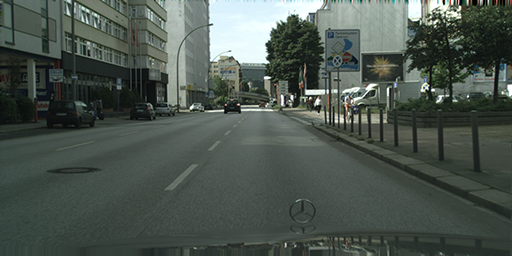
        </td>
        <td>
        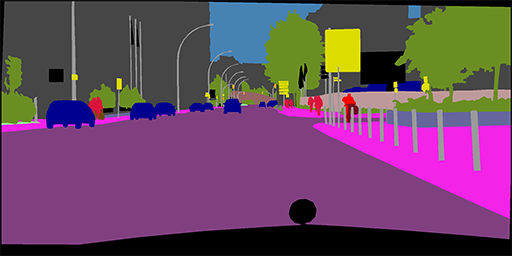
        </td>
    </tr>
    <tr>
        <td>Picture from the Cityscapes dataset.</td>
        <td>Semantic class assigned to each pixel. Every unique color corresponds to one class.</td>
    </tr>
</tbody>
</table>

Once you have a working solution, you can submit your output to the Cityscapes benchmark by creating an account and following [this link](https://www.cityscapes-dataset.com/submit/). We're excited to see where you will show up in the leaderboards!

Remember that this assignment determines 50% of your final grade. This amounts to **50 hours of active work** per student. Additionally, training your neural network will likely take many hours, take this into account when making your working schedule. This notebook downloads the required data for the benchmark and sets up a training pipeline so you can focus on creating networks using the skills you learned during this course. Some exercises have been included to get you started. Join us during computer class or message an assistant if you have any questions.

## Deliverables

Write a paper (one per group) in which you briefly introduce the problem, a baseline approach, your own addition(s), results and  conclusions. Use the **[IEEE double-column format](https://www.overleaf.com/latex/templates/ieee-conference-template/grfzhhncsfqn)** and **max. 4 pages**. You are allowed and expected to use ideas from literature and on the internet. Make sure you properly cite all the relevant sources in your paper. The assignment will be graded on paper quality, experimental setup, demonstrated insight and originality. What we at least expect is:

- Introduction to the problem: What are challenges? What are logical options to address them? What has been done for this or similar problems?
- Baseline implementation and results, using an off-the-shelf segmentation model.
- Improvements to that baseline, backed with experiments and results. Motivate your choices and explain your observations.
- Discussion on limitations and options to further improve.
- Clear and concise figures and tables to support your findings.

Submit your report and code to Canvas when you're finished.

## Requirements

You need at least Python version 3.7. The prefered library for creating your network is PyTorch. All third-party packages you need to run this notebook are imported below, such that you can install any missing dependencies before getting started.

In [ ]:
# Using google colab. Run this cell every time the ipynb is opened on google colab.
# # Edit -> Setting -> GPU
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/TUe/CNN4CV/Assignment4_CityScapes') #root dir

!pwd

/home/mist


In [ ]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%matplotlib inline


In [ ]:
# check device name
print(torch.cuda.get_device_name())
# check if cudnn is available
print(torch.backends.cudnn.enabled)


NVIDIA GeForce GTX 1070 Ti
True


## Downloading and preprocessing the ground truth and input files
Let's start with downloading a ZIP-file that contains the training, testing and validation datasets.

In [ ]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve

# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = os.path.abspath('/content/drive/MyDrive/TUe/CNN4CV/Assignment4_CityScapes/data')

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://flux127120.nbw.tue.nl/index.php/s/Cwxa5Ft2pQBK9N7/download'
dir_truth = os.path.join(dir_data, "gtFine")

url_input = 'https://flux127120.nbw.tue.nl/index.php/s/Tz3GCjQwwsiHgqC/download'
dir_input = os.path.join(dir_data, "leftImg8bit")

# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()
        
        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')
        
# Done!
print(f'All data downloaded')



The downloaded images are very large. A consumer-grade PC likely does not have enough GPU-memory or data bandwidth to create a viable implementation in the original size. For this reason, we run a pre-processing step on the dataset that downscales all images. Once you have a working model, you may consider using a larger `sample_size`.

In [ ]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve
# between you and your assignment partner.
dir_data = os.path.abspath('data_low')

dir_truth = os.path.join(dir_data, "gtFine")

dir_input = os.path.join(dir_data, "leftImg8bit")


In [ ]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue
        
    print(f'Preprocessing: {dir_full}')
        
    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue
            
        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')
        
        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)
        
        for f in files:
            if not f.endswith('.png'):
                continue
            
            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)
            
print(f'Preprocessing done')


Preprocessed directory already exists: /home/mist/data_low/gtFine_256_128
Preprocessed directory already exists: /home/mist/data_low/leftImg8bit_256_128
Preprocessing done


## Data structures

Now that our data has been downloaded, we can proceed to define some data structures to model the structure of the provided data. Each semantic class that we aim to detect has a unique name, id and color. For more information on the datset, view [this link](https://www.cityscapes-dataset.com/dataset-overview/).

In [ ]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str
    
    @property
    def id(self):
        return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id]))
    
    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+).*.png$", filename, re.I)
        return CityscapesSample(match.group(1), match.group(2), match.group(3))
            
    
# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str
    id: int
    color: Tuple[int, int, int]

# List of classes that we want to detect in the input
classes = [
    CityscapesClass('void', 0, (0, 0, 0)),
    CityscapesClass('dynamic', 1, (111, 74, 0)),
    CityscapesClass('ground', 2, (81, 0, 81)),
    CityscapesClass('road', 3, (128, 64, 128)),
    CityscapesClass('sidewalk', 4, (244, 35, 232)),
    CityscapesClass('parking', 5, (250, 170, 160)),
    CityscapesClass('rail track', 6, (230, 150, 140)),
    CityscapesClass('building', 7, (70, 70, 70)),
    CityscapesClass('wall', 8, (102, 102, 156)),
    CityscapesClass('fence', 9, (190, 153, 153)),
    CityscapesClass('guard rail', 10, (180, 165, 180)),
    CityscapesClass('bridge', 11, (150, 100, 100)),
    CityscapesClass('tunnel', 12, (150, 120, 90)),
    CityscapesClass('pole', 13, (153, 153, 153)),
    CityscapesClass('polegroup', 14, (153, 153, 153)),
    CityscapesClass('traffic light', 15, (250, 170, 30)),
    CityscapesClass('traffic sign', 16, (220, 220, 0)),
    CityscapesClass('vegetation', 17, (107, 142, 35)),
    CityscapesClass('terrain', 18, (152, 251, 152)),
    CityscapesClass('sky', 19, (70, 130, 180)),
    CityscapesClass('person', 20, (220, 20, 60)),
    CityscapesClass('rider', 21, (255, 0, 0)),
    CityscapesClass('car', 22, (0, 0, 142)),
    CityscapesClass('truck', 23, (0, 0, 70)),
    CityscapesClass('bus', 24, (0, 60, 100)),
    CityscapesClass('caravan', 25, (0, 0, 90)),
    CityscapesClass('trailer', 26, (0, 0, 110)),
    CityscapesClass('train', 27, (0, 80, 100)),
    CityscapesClass('motorcycle', 28, (0, 0, 230)),
    CityscapesClass('bicycle', 29, (119, 11, 32)),
]


## Dataset implementation

This section implements a [PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). It transforms image and target colorization pairs from the downloaded files into pairs of input and ground truth tensors. The ground truths are single-channel images where the value of each pixel is equal to the ID of the class represented by the color in the target. This will enable us to train the network using cross-entropy. 

In [ ]:
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List

import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import random

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample],aug=[]):
        super(CityscapesDataset,self).__init__()
        
        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes
        self.aug = aug # switch for random augmentation methods, str or list in ['HFlip','ResizedCrop','GaussianBlur','Rotate','Brightness']
        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]
        input = self.load_input(sample)
        truth = self.load_truth(sample)
        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        # original images 
        path = os.path.join(self.dir_input, f'{sample.id}_leftImg8bit.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        # TODO:combine three different data augmentation methods and compare with single methods
        # random crop and resize back to original size, same on masks
        # disortation
        # gaussian blur
        # horizontally flip, same on masks
        ##################################################################################
        imgshower = transforms.ToPILImage() # code imgshower(img or tensor).show() to check img 
        # Convert the image to a tensor
        img = TF.to_tensor(img)
        
        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        if random.random()>0.8 and len(self.aug)>0: # data augmentation with possibility=0.5
            if 'HFlip' in self.aug:
                img = TF.hflip(img)
                mask = TF.hflip(mask)
                # print(img.size())
                # print(mask.size)
            if 'ResizedCrop' in self.aug and random.random()>0.5: # Is this good for small objects?
                cropper_size = (128,256)
                resize_cropper = transforms.RandomResizedCrop(size = cropper_size)
                i,j,h,w = resize_cropper.get_params(img,scale=(0.6,1.0),ratio=(2,2))
                img = TF.resized_crop(img,i,j,h,w,size=cropper_size) #(3,128,256)
                mask = TF.resized_crop(mask,i,j,h,w,size=cropper_size)
            if 'GaussianBlur' in self.aug:
                blurrer = transforms.GaussianBlur(kernel_size=3,sigma=0.5)
                img = blurrer(img)
                # print('GaussianBlur finish')
            if 'Rotate' in self.aug:
                rotater = transforms.RandomRotation(degrees=(-15,15))
                degree = rotater.get_params(degrees=(-15,15))
                img = TF.rotate(img,degree)
                mask = TF.rotate(mask,degree)
            if 'Brightness' in self.aug:
                b = random.random() + 0.5 # range(0.5,1.5)
                img = TF.adjust_brightness(img,b)
        ################################################################################# 
        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)

        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            temp = eq * i
            target += temp

        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(i)

            target[0] += eq * lbl.color[0]
            target[1] += eq * lbl.color[1]
            target[2] += eq * lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')


The Cityscapes dataset is split in three parts: `train`, `val` and `test`. If everything is set-up correctly, we should be able to draw a random sample from each split, convert it back to an image, and display it.


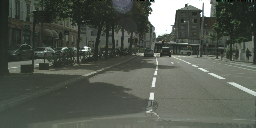
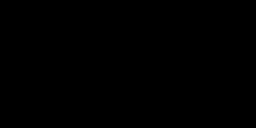

In [ ]:
from IPython.display import display, HTML
from io import BytesIO
from base64 import b64encode

import random

import time

time.sleep(1)
    
# Create one instance of the CityscapesDataset for each split type
ds_split_try = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug='HFlip')
    for name in ("train", "val", "test")
}
# HTML templates for displaying random samples in a table
template_table = '<table><thead><tr><th>Subset</th><th>Amount</th><th>Size</th><th>Input sample</th><th>Truth sample</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td></tr>'
template_img = '<img src="data:image/png;base64,{0}"/>'

# Display a random sample of each split of the dataset
rows = []
for name, ds_sub in ds_split_try.items():    
    # Draw a random sample from the dataset so that we can convert it back to an image
    input, truth = random.choice(ds_sub)
    
    input = TF.to_pil_image(input)
    truth = ds_sub.to_image(truth)
    
    # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
    with BytesIO() as buffer_input, BytesIO() as buffer_truth: 
        input.save(buffer_input, format='png')
        truth.save(buffer_truth, format='png')

        # Store one row of the dataset
        images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_input, buffer_truth)]
        rows.append(template_row.format(name, len(ds_sub), '&times;'.join([str(s) for s in input.size]), *images))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

del ds_split_try


Notice that the `test` set has no ground truth labels, as this is the set used to score competitors' networks against each other. If you submit the best network that you have created to the Cityscapes competition, this is the set that is used to calculate your score.

## Calculating accuracy
Your score on the benchmark will be calculated according to the the intersection-over-union (IoU) metric. [This link](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task) describes how it is implemented in the testing suite. 

The function below is thus a measure for the accuracy of your solution. The `output` parameter represents the output of your network: a batch of multi-dimensional images with one channel per class. For every pixel, the class ID can be calculated by taking the index of the channel containing the maximum value. The `truths` parameter is a batch of ground truths from the `CityscapesDataset` defined above.

In [ ]:
def compute_iou(output: torch.Tensor, truths: torch.Tensor) -> float:
    output = output.detach() #TODO:detached from the compute graph. The result will never require gradient. GDT
    truths = truths.detach()
    
    ## EXERCISE #####################################################################
    #
    # Implement the IoU metric that is used by the benchmark to grade your results.
    #     
    # `output` is a tensor of dimensions [Batch, Classes, Height, Width]
    # `truths` is a tensor of dimensions [Batch, Height, Width]
    #
    # Tip: Peform a sanity check that tests your implementation on a user-defined 
    #      tensor for which you know what the output should be.
    #
    ################################################################################# 

    """
    Material for the final report: referred this link https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task
    The standard Jaccard Index,IoU = TP/(TP+FP+FN),two separate mean performance scores:category and class. 
    However, in this assignment, only the classes.
    In either case, pixels labeled as void do not contribute to the score.
    To mitigate the bias toward object instances that cover a large image area, an instance-level IoU is implemented.
    In a nutshell, TP and FN are weighted to iTP and iFN. The weighting factor is the ratio of the class' average instance size to the
    size of respective ground truth instance.    
    """
    # Choose a device to run training on. Ideally, you have a GPU available to accelerate the training process.

    output = torch.argmax(output,1)  #[Batch, Height, Width]
    TP, FN, FP = 0,0,0
    for i in range(1,30):
        output_log = output == i # pixels in output where class==i
        truth_log = truths == i # pixels in truth where class==i
        TP += torch.sum((output_log==True)&(truth_log==True)) # number of pixels where output class==truth class==i
        FN += torch.sum((output_log==False)&(truth_log==True)) # number of pixels where output!=i, truth==i
        FP += torch.sum((output_log==True)&(truth_log==False)) # number of pixels where output==i, truth!=i 
    iou = torch.divide(TP,TP+FN+FP+1e-6)
    #################################################################################
    return iou.item()

In [ ]:
#testing compute iou in cuda and cpu

y_true=torch.tensor([[[0,1,2],[0,2,1]]])
y_pred=torch.tensor([[[[0,0,1],[0,1,0]],[[0,1,0],[1,0,1]],[[1,0,0],[0,0,0]]]])

iou_test_device = "cuda"
if not torch.cuda.is_available():
  y_true = y_true.cpu()
  y_pred = y_pred.cpu()

iou = compute_iou(y_pred,y_true)
print(f'IoU computation test on {iou_test_device}:{iou}')


IoU computation test on cuda:0.333333283662796


## Training setup
The final step before you can implement your networks is to define the training process.

In [ ]:
from torch import nn, optim
from torch.utils.data import DataLoader
    
class Trainer:
    def __init__(self, model: nn.Module, ds_split: Dict[str,CityscapesDataset], epochs=1, batch_size=10):
        # Choose a device to run training on. Ideally, you have a GPU available to accelerate the training process.
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Move the model onto the target device
        self.model = model.to(self.device)
        
        # Store the dataset split
        self.ds_split = ds_split
        
        ## EXERCISE #####################################################################
        #
        # Select an optimizer
        #
        # See: https://pytorch.org/docs/stable/optim.html
        #
        ################################################################################# 
        
        self.optimizer = optim.Adam(model.parameters(),lr=0.001) #model.parameters(): return an iterator over module parameters
        
        ## EXERCISE #####################################################################
        #
        # Select an appropriate loss function
        #
        # See: https://pytorch.org/docs/stable/nn.html#loss-functions
        #
        ################################################################################# 
        
        self.critereon = torch.nn.CrossEntropyLoss() # Cross Entropy Loss for multi-classfication tasks
        
        #################################################################################
        self.epochs = epochs
        self.batch_size = batch_size
        
        assert self.critereon is not None, "You have not defined a loss"
        assert self.optimizer is not None, "You have not defined an optimizer"
        
    def train_epoch(self, dl:DataLoader):
        # Put the model in training mode
        self.model.train()
        
        # Store each step's accuracy and loss for this epoch
        epoch_metrics = {
            "loss": [],
            "accuracy": []
        }
        
        # Create a progress bar using TQDM
        sys.stdout.flush()
        with tqdm(total=len(self.ds_split["train"]), desc=f'Training') as pbar:
            # Iterate over the training dataset
            for inputs, truths in dl:
                # Zero the gradients from the previous step
                self.optimizer.zero_grad()
                
                # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)
                
                # Run model on the inputs
                output = self.model(inputs)

                # Perform backpropagation
                loss = self.critereon(output, truths)
                loss.backward()
                nn.utils.clip_grad_value_(self.model.parameters(), 0.1) # max allowed gradient value 0.1 to avoid gradient expose
                self.optimizer.step()
                
                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }
                
                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])
                
                # Add to epoch's metrics
                for k,v in step_metrics.items():
                    epoch_metrics[k].append(v)

        sys.stdout.flush()
        
        # Return metrics
        return epoch_metrics
    
    def val_epoch(self, dl:DataLoader):
        # Put the model in evaluation mode
        self.model.eval()
        
        # Store the total loss and accuracy over the epoch
        amount = 0
        total_loss = 0
        total_accuracy = 0
        
        # Create a progress bar using TQDM
        sys.stdout.flush()
        with torch.no_grad(), tqdm(total=len(self.ds_split["val"]), desc=f'Validation') as pbar:
            # Iterate over the validation dataloader
            for inputs, truths in dl:
                 # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)
                loss = self.critereon(output, truths)

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                amount += 1
                total_loss += step_metrics["loss"]
                total_accuracy += step_metrics["accuracy"]
        sys.stdout.flush()
        
        # Print mean of metrics
        total_loss /= amount
        total_accuracy /= amount
        print(f'Validation loss is {total_loss}, validation accuracy is {total_accuracy}')
              
        # Return mean loss and accuracy
        return {
            "loss": [total_loss],
            "accuracy": [total_accuracy]
        }
            
        
    def fit(self):
        # Initialize Dataloaders for the `train` and `val` splits of the dataset. 
        # A Dataloader loads a batch of samples from the each dataset split and concatenates these samples into a batch.
        epochs = self.epochs
        batch_size = self.batch_size

        dl_train = DataLoader(self.ds_split["train"], batch_size=batch_size, shuffle=True,num_workers=4)
        dl_val = DataLoader(self.ds_split["val"], batch_size=batch_size, drop_last=True,num_workers=4)
                
        # Store metrics of the training process (plot this to gain insight)
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()
        
        # Train the model for the provided amount of epochs
        for epoch in range(1, epochs+1):
            print(f'Epoch {epoch}')
            metrics_train = self.train_epoch(dl_train)
            df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)
            
            metrics_val = self.val_epoch(dl_val)
        
            df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True) 
        
        del dl_train
        del dl_val

        # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
        return df_train, df_val


We can do a quick sanity check by creating a pass-through network that transforms the expected input shape into the output shape. While we don't expect this to solve the semantic segmentation problem, it does provide a way to test whether the inputs, truths and outputs are passed through the `Trainer` class correctly.

In [ ]:
# Create one instance of the CityscapesDataset for each split type
ds_split_pass_through = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes, aug=['HFlip','ResizedCrop','GaussianBlur'])
    for name in ("train", "val", "test")
}

Testing training process...
Epoch 1


Validation: 100%|██████████| 500/500 [00:01<00:00, 285.86it/s, accuracy=0.0875, loss=3.37]

Validation loss is 0.06731282405853271, validation accuracy is 0.1084558755159378
Epoch 2



Validation: 100%|██████████| 500/500 [00:01<00:00, 295.10it/s, accuracy=0.0817, loss=3.31]

Validation loss is 0.06597151222229004, validation accuracy is 0.10974853992462158
Epoch 3



Validation: 100%|██████████| 500/500 [00:01<00:00, 285.64it/s, accuracy=0.219, loss=3.24]


Validation loss is 0.06462801342010498, validation accuracy is 0.2128164778649807



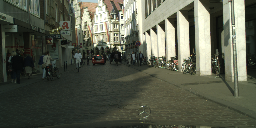
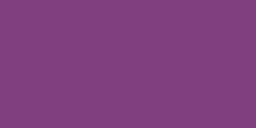
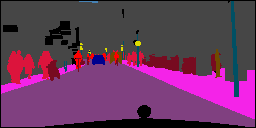

In [ ]:
from torch import nn
import torch.nn.functional as F

# Define a module that transforms: RGB-channel image -> len(classes)-channel image
class Passthrough(nn.Module):
    def __init__(self, n_channels=3, n_classes=len(classes)):
        super().__init__()
        
        self.transform = nn.Conv2d(n_channels, n_classes, 1)
        
    def forward(self, x):
        x = F.softmax(self.transform(x), dim=1)
        return x

model = Passthrough()

# Train the passthrough network
print("Testing training process...")
trainer_passthrough = Trainer(model, ds_split_pass_through,epochs=3, batch_size=10)
# use IoU rather than iIoU
mit_bias = False
df_train, df_val = trainer_passthrough.fit()

# Draw a random sample
input, truth = random.choice(ds_split_pass_through["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_pass_through["val"].to_image(ds_split_pass_through["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_pass_through["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))


If the section above ran without errors, then you are ready to continue.

## Define a baseline
You should start by implementing a network that performs semantic segmentation reasonably well (e.g. [U-Net](https://arxiv.org/pdf/1505.04597.pdf)). This will be the baseline against which you can compare your own improvements.

Training process for UNet Baseline...
Epoch 1


Validation: 100%|██████████| 500/500 [00:13<00:00, 35.89it/s, accuracy=0.63, loss=1.38]

Validation loss is 0.07197587758302688, validation accuracy is 0.5852017804980278
Epoch 2



Validation: 100%|██████████| 500/500 [00:13<00:00, 36.04it/s, accuracy=0.606, loss=0.877]

Validation loss is 0.048748423010110856, validation accuracy is 0.5623542591929436
Epoch 3



Validation: 100%|██████████| 500/500 [00:13<00:00, 36.09it/s, accuracy=0.677, loss=0.736]

Validation loss is 0.042054094076156616, validation accuracy is 0.627210633456707
Epoch 4



Validation: 100%|██████████| 500/500 [00:13<00:00, 36.10it/s, accuracy=0.663, loss=0.737]

Validation loss is 0.04086794748902321, validation accuracy is 0.6204284027218818
Epoch 5



Validation: 100%|██████████| 500/500 [00:13<00:00, 36.21it/s, accuracy=0.735, loss=0.57]


Validation loss is 0.03257942259311676, validation accuracy is 0.687927408516407



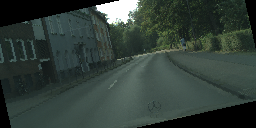
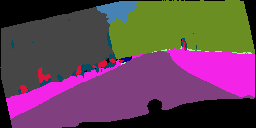
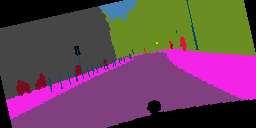

In [ ]:
# Define a baseline from literature

from UNetBaseline.uNet import UNet
from UNetBaseline.initialize_weights_baseline import initialize_weights_baseline

# Create one instance of the CityscapesDataset for each split type
ds_split_UNet_bl = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes, aug=['Rotate'])
    for name in ("train", "val", "test")
}


model_unet_baseline = UNet(3,len(classes))
# Train the passthrough network
print("Training process for UNet Baseline...")
model_unet_baseline.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_unet_baseline, ds_split_UNet_bl,epochs=5, batch_size=25)

# use IoU rather than iIoU
mit_bias = False
df_train, df_val = trainer_unet_baseline.fit() 

# Draw a random sample
input, truth = random.choice(ds_split_UNet_bl["val"])

# Push through our network
model_unet_baseline = model_unet_baseline.cpu()
output = model_unet_baseline(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_UNet_bl["val"].to_image(ds_split_UNet_bl["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_UNet_bl["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

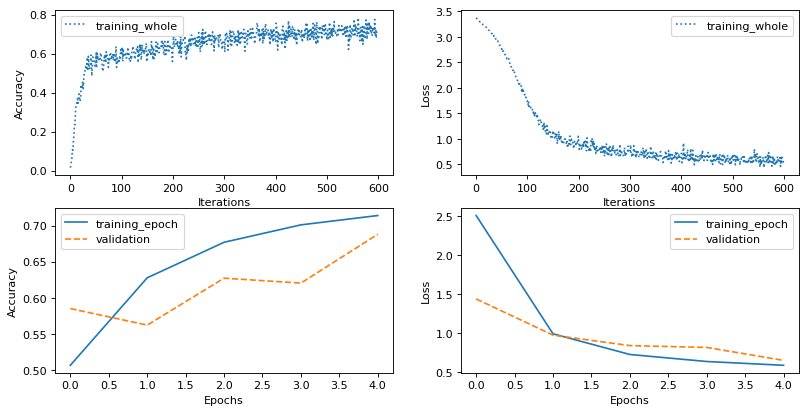

In [ ]:
import log_train_val

def plot_train_val(df_train,df_val,trainer):
  train_acc = df_train.groupby('epoch')['accuracy'].mean()
  train_loss = df_train.groupby('epoch')['loss'].mean()

  fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
  ax = plt.subplot(2,2,1)
  ax.plot(range(len(df_train)),df_train['accuracy'],label='training_whole',linestyle=':')
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Iterations')

  ax = plt.subplot(2,2,2)
  ax.plot(range(len(df_train)),df_train['loss'],label='training_whole',linestyle=':')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Iterations')
  ax.legend()

  ax = plt.subplot(2,2,3)
  ax.plot(range(trainer.epochs), train_acc,label='training_epoch')
  ax.plot(range(trainer.epochs), df_val['accuracy'], label="validation",linestyle='--')
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epochs')

  ax = plt.subplot(2,2,4)
  ax.plot(range(trainer.epochs), train_loss,label='training_epoch')
  ax.plot(range(trainer.epochs), df_val['loss'], label="validation",linestyle='--')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epochs')
  ax.legend()

  plt.show()

import time
# save baseline model
log_time = time.strftime('%d-%m-%Y-%H-%M-%S',time.localtime())
model_root_dir = os.path.abspath('/content/drive/MyDrive/TUe/CNN4CV/Assignment4_CityScapes/UNetBaseline')
model_save_name = f'unetbaseline_{log_time}.pt'
torch.save(model_unet_baseline,f'{model_root_dir}/saved_model/{model_save_name}')

# test log and plot for df_train and df_val
log_train_val.log_train_val(df_train,df_val,"UNet_baseline_IoU",model_root_dir)
plot_train_val(df_train, df_val,trainer_unet_baseline)


##  **Baseline Performance**
*  Epoch=5
*  Train Acc.= 0.723
*  Validation Acc.= 0.735

## colab学习笔记：保存和加载模型，checkpoint
Ref:https://zhuanlan.zhihu.com/p/38056115
* Save entire model

```
root_dir = '/content/drive/MyDrive/TUe/CNN4CV/Assignment4_CityScapes'
torch.save(model_unet_baseline,f'{root_dir}/UNetBaseline/saved_model')
```
* load model
```
model = torch.load(f'{root_dir}/UNetBaseline/saved_model)
model.eval() #set BN layer to evaluation mode
```
* save checkpoint
```
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)
```
* load checkpoint
```
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.eval()
 - or -
model.train()
```

## Create your own network
You can now start building upon your baseline network to improve accuracy on the validation dataset. Some directions that you should explore are:
- Data augmentation (see exercise in the `CityscapesDataset` class)
- Model architecture changes
- Hyperparameter tuning

Remember to save data and figures for your paper, and clearly explain your design choices.

## 计划
    *   Model1: 更浅的网络，因为图片太小了。提高训练速度，同时减少信息损失。提高epoch到10看看overfitting
    *   Model2: 混合空洞卷积HDC替代maxpooling
    *   Model3：We should try another weight initialization instead of gaussian.对比Xavier和Kaiming 
    *   数据集: Data Augmentation, crop, gaussian blur, brightness, rotation

## 笔记

    *   Google Colab的GPU使用了1'22''34'''结束，训练了baseline，epoch=10.
    *   由于计算资源限制，随机增强原图像，inplace替换。
    *   log 22.04.16: 重新训练仅有resized crop作为数据增强。
      观察到之前的代码训练之后并没有提高对小物体的识别效果。
      之前的比例失真了，注意ratio是期望的横纵比（注意，是图片的width/height，之前以为是纵横比)。
      pytorch处理tensor的时候是按照最后两个维度分别是height和width，








In [ ]:
# Create one instance of the CityscapesDataset for each split type
ds_split_UNet_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes, aug=['Rotate'])
    for name in ("train", "val", "test")
}

## Shallow Unet

Training process for shallow_UNet...
Epoch 1


Validation: 100%|██████████| 500/500 [02:14<00:00,  3.72it/s, accuracy=0.547, loss=1.44]

Validation loss is 0.07347259014844895, validation accuracy is 0.5048833265900612
Epoch 2



Validation: 100%|██████████| 500/500 [00:13<00:00, 37.65it/s, accuracy=0.709, loss=0.753]

Validation loss is 0.04183222219347954, validation accuracy is 0.6617521584033966
Epoch 3



Validation: 100%|██████████| 500/500 [00:12<00:00, 38.61it/s, accuracy=0.731, loss=0.631]

Validation loss is 0.036602814495563504, validation accuracy is 0.6745023310184479
Epoch 4



Validation: 100%|██████████| 500/500 [00:13<00:00, 36.49it/s, accuracy=0.72, loss=0.613]

Validation loss is 0.03718599267303944, validation accuracy is 0.662279249727726
Epoch 5



Validation: 100%|██████████| 500/500 [00:13<00:00, 37.88it/s, accuracy=0.719, loss=0.621]


Validation loss is 0.035000919476151464, validation accuracy is 0.673640887439251



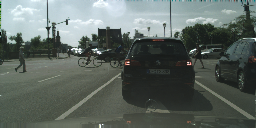
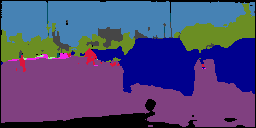
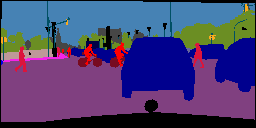

In [ ]:
# Create your own solution

# Model 1 shallow UNet
from Model1.shallow_uNet import shallow_UNet
from Model1.initialize_weights_baseline import initialize_weights_baseline

model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet...")
model_shallow_unet.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_UNet_shallow,epochs=5, batch_size=25)

df_train_shallow, df_val_shallow = trainer_unet_baseline.fit()

# Draw a random sample
input, truth = random.choice(ds_split_UNet_shallow["val"])

# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_UNet_shallow["val"].to_image(ds_split_UNet_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_UNet_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))


Train accuracy in each epoch:epoch
1    0.485782
2    0.641135
3    0.689664
4    0.715148
5    0.730966
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.578748
1    0.647043
2    0.678377
3    0.707903
4    0.693944
Name: accuracy, dtype: float64


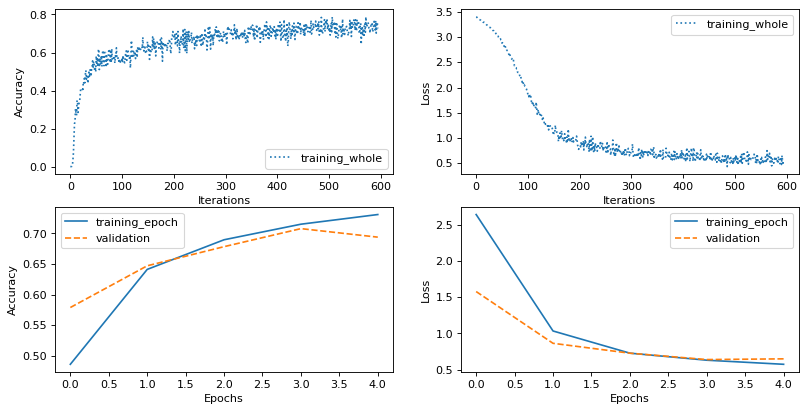

In [ ]:
# illustration of model 1 and aug=['HFlip','GaussianBlur']

import time

def plot_train_val(df_train,df_val,trainer):
  train_acc = df_train.groupby('epoch')['accuracy'].mean()
  train_loss = df_train.groupby('epoch')['loss'].mean()

  fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
  ax = plt.subplot(2,2,1)
  ax.plot(range(len(df_train)),df_train['accuracy'],label='training_whole',linestyle=':')
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Iterations')

  ax = plt.subplot(2,2,2)
  ax.plot(range(len(df_train)),df_train['loss'],label='training_whole',linestyle=':')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Iterations')
  ax.legend()

  ax = plt.subplot(2,2,3)
  ax.plot(range(trainer.epochs), train_acc,label='training_epoch')
  ax.plot(range(trainer.epochs), df_val['accuracy'], label="validation",linestyle='--')
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epochs')
  print(f'Train accuracy in each epoch:{train_acc}.')
  print('Validation accuracy in each epoch.\n')
  print(df_val['accuracy'])

  ax = plt.subplot(2,2,4)
  ax.plot(range(trainer.epochs), train_loss,label='training_epoch')
  ax.plot(range(trainer.epochs), df_val['loss'], label="validation",linestyle='--')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epochs')
  ax.legend()

  plt.show()

# test log and plot for df_train and df_val
# log_train_val.log_train_val(df_train_shallow, df_val_shallow,"shallow_unet_IoU",model_root_dir)
plot_train_val(df_train_shallow, df_val_shallow,trainer_unet_baseline)

##  **Shallow UNet Performance**
*  Epoch=5
*  Train Acc.= 检查记录表
*  Validation Acc.= 检查记录表
*  For low resolution images, shallower UNet does reduce accuracy.
*  However, due to computation resource limitation, it is not tested for more epochs.

## Aug = 'HFlip', 'GaussianBlur'

In [ ]:
# Create one instance of the CityscapesDataset for each split type
ds_split_aug_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['HFlip','GaussianBlur'])
    for name in ("train", "val", "test")
}

Training process for shallow_UNet with aug=['HFlip','GaussianBlur']...
Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 115.86it/s, accuracy=0.661, loss=1.33]

Validation loss is 0.07186752051115036, validation accuracy is 0.5948459178209304
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.88it/s, accuracy=0.709, loss=0.673]

Validation loss is 0.0432682266831398, validation accuracy is 0.6302622124552727
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 115.71it/s, accuracy=0.743, loss=0.574]

Validation loss is 0.03735811084508896, validation accuracy is 0.6726390391588211
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 116.06it/s, accuracy=0.734, loss=0.577]

Validation loss is 0.035736201405525206, validation accuracy is 0.6700734794139862
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.92it/s, accuracy=0.782, loss=0.455]


Validation loss is 0.03136947311460972, validation accuracy is 0.705133730173111



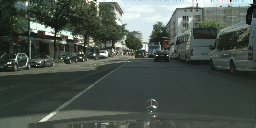
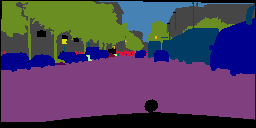

In [ ]:
# train model 1 with augmentation aug=['HFlip','GaussianBlur']

# Model 1 shallow UNet
from Model1.shallow_uNet import shallow_UNet
from Model1.initialize_weights_baseline import initialize_weights_baseline

model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet with aug=['HFlip','GaussianBlur']...")
model_shallow_unet.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug_shallow,epochs=5, batch_size=25)

# use IoU rather than iIoU
mit_bias = False
df_train_shallow, df_val_shallow = trainer_unet_baseline.fit()

# Draw a random sample
input, truth = random.choice(ds_split_aug_shallow["val"])

# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug_shallow["val"].to_image(ds_split_aug_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

Train accuracy in each epoch:epoch
1    0.502562
2    0.635974
3    0.692458
4    0.716911
5    0.730113
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.594846
1    0.630262
2    0.672639
3    0.670073
4    0.705134
Name: accuracy, dtype: float64


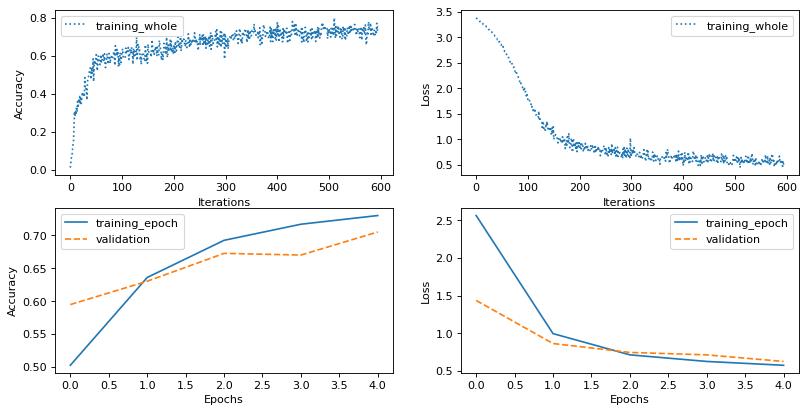

In [ ]:
# illustration of model 1 and aug=['HFlip','GaussianBlur']
print('Illustration of shallwo Unet with aug=['HFlip','GaussianBlur']')
plot_train_val(df_train_shallow, df_val_shallow,trainer_unet_baseline)

In [ ]:
# Create one instance of the CityscapesDataset for each split type
ds_split_aug2_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['ResizedCrop'])
    for name in ("train", "val", "test")
}

Training process for shallow_UNet with aug=['ResizedCrop']...
Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 114.45it/s, accuracy=0.631, loss=1.38]

Validation loss is 0.07586264431476593, validation accuracy is 0.5641854703426361
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.94it/s, accuracy=0.729, loss=0.69] 

Validation loss is 0.045938778221607204, validation accuracy is 0.6295044347643852
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.09it/s, accuracy=0.714, loss=0.638]

Validation loss is 0.042121643424034114, validation accuracy is 0.6346414759755135
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.89it/s, accuracy=0.778, loss=0.51] 

Validation loss is 0.03474902257323265, validation accuracy is 0.6958860665559768
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.72it/s, accuracy=0.779, loss=0.472]


Validation loss is 0.03246322177350521, validation accuracy is 0.7019435971975326



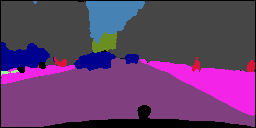

In [ ]:
# train model 1 with augmentation aug=['ResizedCrop']

# Model 1 shallow UNet
from Model1.shallow_uNet import shallow_UNet
from Model1.initialize_weights_baseline import initialize_weights_baseline

model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet with aug=['ResizedCrop']...")
model_shallow_unet.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug2_shallow,epochs=5, batch_size=25)

# use IoU rather than iIoU
mit_bias = False
df_train_shallow, df_val_shallow = trainer_unet_baseline.fit()

# Draw a random sample
input, truth = random.choice(ds_split_aug2_shallow["val"])

# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug2_shallow["val"].to_image(ds_split_aug2_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug2_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

In [ ]:
print('Illustration of shallwo Unet with aug=ResizedCrop')
plot_train_val(df_train_shallow, df_val_shallow,trainer_unet_baseline)

Illustration of shallwo Unet with aug=ResizedCrop
Train accuracy in each epoch:epoch
1    0.505938
2    0.629844
3    0.686739
4    0.713872
5    0.725025
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.564185
1    0.629504
2    0.634641
3    0.695886
4    0.701944
Name: accuracy, dtype: float64


##  accuracy is still increasing. Train with aug=['ResizedCrop'] again but more epochs (5->10).

Training process for shallow_UNet with aug=['ResizedCrop']...
Epoch 1


Validation: 100%|██████████| 500/500 [00:31<00:00, 15.73it/s, accuracy=0.141, loss=1.57]

Validation loss is 0.08033041685819627, validation accuracy is 0.12738632187247276
Epoch 2



Validation: 100%|██████████| 500/500 [00:31<00:00, 15.85it/s, accuracy=0.172, loss=0.965]

Validation loss is 0.05108775466680526, validation accuracy is 0.1643145453184843
Epoch 3



Validation: 100%|██████████| 500/500 [00:32<00:00, 15.45it/s, accuracy=0.207, loss=0.753]

Validation loss is 0.04321003377437592, validation accuracy is 0.18505876511335373
Epoch 4



Validation: 100%|██████████| 500/500 [00:31<00:00, 15.64it/s, accuracy=0.217, loss=0.713]

Validation loss is 0.04125091850757599, validation accuracy is 0.19374363198876382
Epoch 5



Validation: 100%|██████████| 500/500 [00:32<00:00, 15.58it/s, accuracy=0.225, loss=0.694]

Validation loss is 0.037923951223492625, validation accuracy is 0.2160920023918152
Epoch 6



Validation: 100%|██████████| 500/500 [00:31<00:00, 15.65it/s, accuracy=0.238, loss=0.615]

Validation loss is 0.03699301697313785, validation accuracy is 0.2092037096619606
Epoch 7



Validation: 100%|██████████| 500/500 [00:31<00:00, 15.65it/s, accuracy=0.256, loss=0.584]

Validation loss is 0.03290438309311867, validation accuracy is 0.23057145103812218
Epoch 8



Validation: 100%|██████████| 500/500 [00:32<00:00, 15.62it/s, accuracy=0.257, loss=0.548]

Validation loss is 0.03170337356626988, validation accuracy is 0.23069015815854071
Epoch 9



Validation: 100%|██████████| 500/500 [00:31<00:00, 15.66it/s, accuracy=0.269, loss=0.514]

Validation loss is 0.028758404329419136, validation accuracy is 0.2555591993033886
Epoch 10



Validation: 100%|██████████| 500/500 [00:31<00:00, 15.75it/s, accuracy=0.281, loss=0.5]


Validation loss is 0.02873291805386543, validation accuracy is 0.26054951176047325



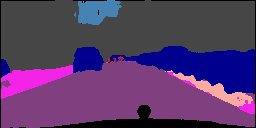

In [ ]:
# train model 1 with augmentation aug=['ResizedCrop'] again but 10 epochs

# Model 1 shallow UNet
from Model1.shallow_uNet import shallow_UNet
from Model1.initialize_weights_baseline import initialize_weights_baseline

model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet with aug=['ResizedCrop']...")
model_shallow_unet.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug2_shallow,epochs=10, batch_size=25)

df_train_shallow, df_val_shallow = trainer_unet_baseline.fit()

# Draw a random sample
input, truth = random.choice(ds_split_aug2_shallow["val"])

# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug2_shallow["val"].to_image(ds_split_aug2_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug2_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

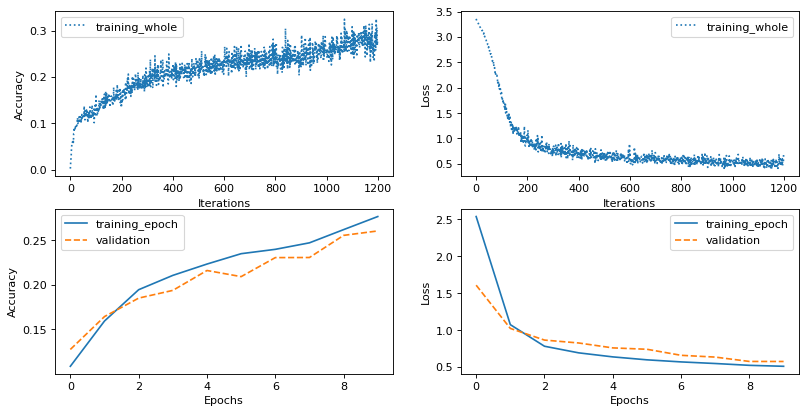

In [ ]:
print('Illustration of shallwo Unet with aug=['ResizedCrop']')
plot_train_val(df_train_shallow, df_val_shallow,trainer_unet_baseline)

* Shallow UNet performance almost same as UNet baseline
* But training and inference is faster.
* Accuracy is still ascending. Given more epochs, the result will be better.
* Before that, data augmentation is implemented. Base on the result, the network works not well on small objects. This is because maxpooling layers and the low resolution images.

In [ ]:
# Create one instance of the CityscapesDataset for each split type
del ds_split_aug2_shallow
ds_split_aug3_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['ResizedCrop','HFlip'])
    for name in ("train", "val", "test")
}

Training process for shallow_UNet with aug=['ResizedCrop','HFlip']...
Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 115.59it/s, accuracy=0.598, loss=1.47]

Validation loss is 0.07851490765810012, validation accuracy is 0.5563838884234429
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.67it/s, accuracy=0.72, loss=0.7]   

Validation loss is 0.04533150210976601, validation accuracy is 0.641170185804367
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.44it/s, accuracy=0.728, loss=0.645]

Validation loss is 0.0446427159011364, validation accuracy is 0.630629213154316
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.47it/s, accuracy=0.774, loss=0.51] 

Validation loss is 0.036128329187631605, validation accuracy is 0.6752295106649399
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.49it/s, accuracy=0.763, loss=0.541]


Validation loss is 0.03442159980535507, validation accuracy is 0.6973328411579132



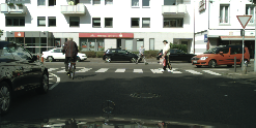
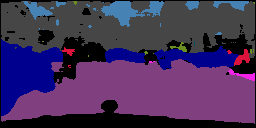
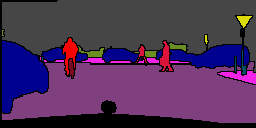

In [ ]:
# train model 1 with augmentation aug=['ResizedCrop','HFlip']

# Model 1 shallow UNet
from Model1.shallow_uNet import shallow_UNet
from Model1.initialize_weights_baseline import initialize_weights_baseline

model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet with aug=['ResizedCrop','HFlip']...")
model_shallow_unet.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug3_shallow,epochs=5, batch_size=25)

# use IoU rather than iIoU
mit_bias = False
df_train_shallow, df_val_shallow = trainer_unet_baseline.fit()

# Draw a random sample
input, truth = random.choice(ds_split_aug3_shallow["val"])

# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug3_shallow["val"].to_image(ds_split_aug3_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug3_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

Illustration of shallwo Unet with aug=[ResizedCrop,Flip]
Train accuracy in each epoch:epoch
1    0.501630
2    0.636135
3    0.688707
4    0.707224
5    0.725127
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.556384
1    0.641170
2    0.630629
3    0.675230
4    0.697333
Name: accuracy, dtype: float64


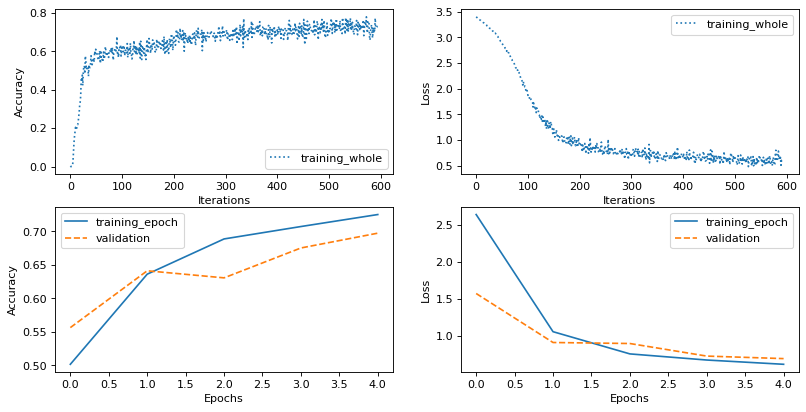

In [ ]:
print('Illustration of shallwo Unet with aug=[ResizedCrop,Flip]')
plot_train_val(df_train_shallow, df_val_shallow,trainer_unet_baseline)

## Work at 17.Apr.22. Train the model with aug=['Brightness'] only.

In [ ]:
# Create one instance of the CityscapesDataset for each split type

del ds_split_aug3_shallow

ds_split_aug4_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['Brightness'])
    for name in ("train", "val", "test")
}

## Train with aug = ['Brightness'] only. Epochs=5.

In [ ]:
# train model 1 with augmentation aug=['Brightness'] only

# Model 1 shallow UNet
from Model1.shallow_uNet import shallow_UNet
from Model1.initialize_weights_baseline import initialize_weights_baseline

model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet with aug=['Brightness']...")
model_shallow_unet.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug4_shallow,epochs=5, batch_size=25)

# use IoU rather than iIoU
mit_bias = False
df_train_shallow, df_val_shallow = trainer_unet_baseline.fit()


Training process for shallow_UNet with aug=['Brightness']...
Epoch 1


Validation: 100%|██████████| 500/500 [10:33<00:00,  1.27s/it, accuracy=0.609, loss=1.39]

Validation loss is 0.07144764989614487, validation accuracy is 0.5826435968279838
Epoch 2



Validation: 100%|██████████| 500/500 [00:21<00:00, 22.95it/s, accuracy=0.706, loss=0.77]

Validation loss is 0.04333340018987656, validation accuracy is 0.6574219912290573
Epoch 3



Validation: 100%|██████████| 500/500 [00:21<00:00, 23.50it/s, accuracy=0.714, loss=0.66]

Validation loss is 0.038010059893131255, validation accuracy is 0.6626923173666001
Epoch 4



Validation: 100%|██████████| 500/500 [00:21<00:00, 23.33it/s, accuracy=0.721, loss=0.598]

Validation loss is 0.03504707470536232, validation accuracy is 0.6711950331926346
Epoch 5



Validation: 100%|██████████| 500/500 [00:21<00:00, 23.59it/s, accuracy=0.752, loss=0.535]

Validation loss is 0.03147494845092297, validation accuracy is 0.7027624100446701


## check result


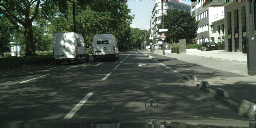
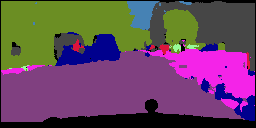
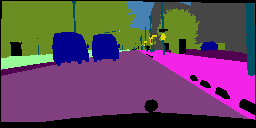

In [ ]:

# Draw a random sample
input, truth = random.choice(ds_split_aug4_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug4_shallow["val"].to_image(ds_split_aug4_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug4_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## check accuracy and loss. log model.

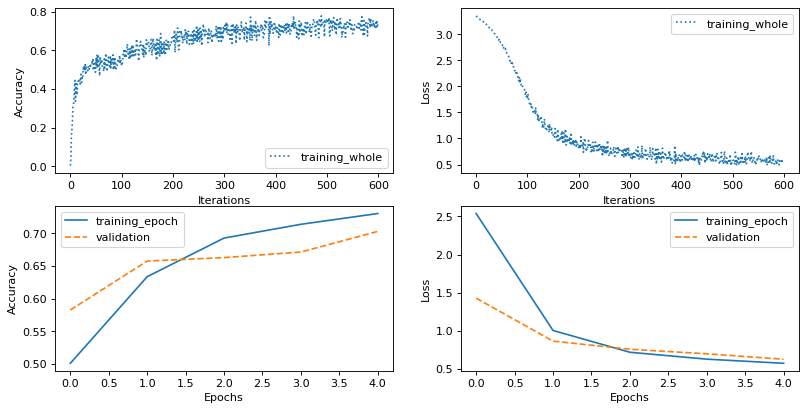

In [ ]:
print('Illustration of shallwo Unet with aug=['Brightness']')
plot_train_val(df_train_shallow, df_val_shallow,trainer_unet_baseline)

## Train with aug=['ResizedCrop','Rotate']

In [ ]:
# Create one instance of the CityscapesDataset for each split type
ds_split_aug5_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['ResizedCrop','Rotate'])
    for name in ("train", "val", "test")
}

In [ ]:
# train model 1 with augmentation aug=['ResizedCrop','Rotate'] only

# Model 1 shallow UNet
from Model1.shallow_uNet import shallow_UNet
from Model1.initialize_weights_baseline import initialize_weights_baseline

model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet with aug=['ResizedCrop','Rotate']...")
model_shallow_unet.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug5_shallow,epochs=5, batch_size=25)

# use IoU rather than iIoU
mit_bias = False
df_train_shallow_aug5, df_val_shallow_aug5 = trainer_unet_baseline.fit()


Training process for shallow_UNet with aug=['ResizedCrop','Rotate']...
Epoch 1


Validation: 100%|██████████| 500/500 [05:11<00:00,  1.60it/s, accuracy=0.509, loss=1.46]

Validation loss is 0.07521041333675385, validation accuracy is 0.47459497153759
Epoch 2



Validation: 100%|██████████| 500/500 [00:13<00:00, 38.02it/s, accuracy=0.684, loss=0.823]

Validation loss is 0.04566600486636162, validation accuracy is 0.6396661758422851
Epoch 3



Validation: 100%|██████████| 500/500 [00:13<00:00, 37.82it/s, accuracy=0.518, loss=1.16]

Validation loss is 0.060527674555778496, validation accuracy is 0.5005181103944778
Epoch 4



Validation: 100%|██████████| 500/500 [00:13<00:00, 37.33it/s, accuracy=0.708, loss=0.651]

Validation loss is 0.037123295813798904, validation accuracy is 0.6712804168462754
Epoch 5



Validation: 100%|██████████| 500/500 [00:13<00:00, 37.72it/s, accuracy=0.746, loss=0.584]

Validation loss is 0.03369519621133804, validation accuracy is 0.6976727694272995



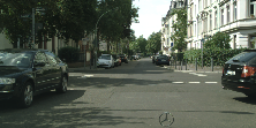
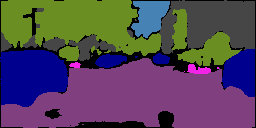
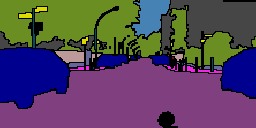

In [ ]:

# Draw a random sample
input, truth = random.choice(ds_split_aug5_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug5_shallow["val"].to_image(ds_split_aug5_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug5_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

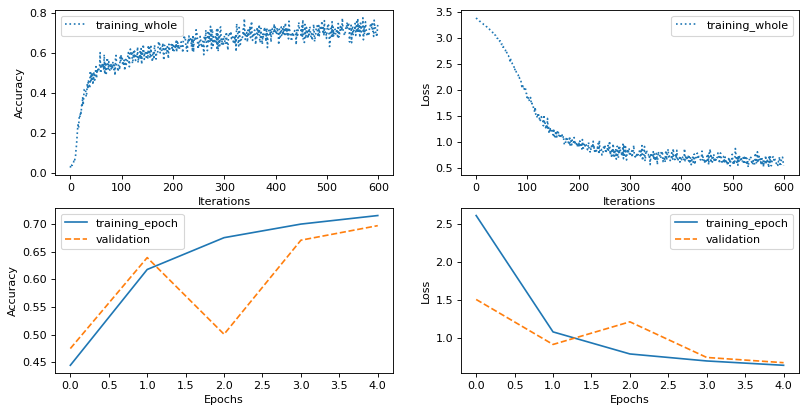

In [ ]:
print('Illustration of shallwo Unet with aug=['ResizedCrop','Rotate']')
plot_train_val(df_train_shallow_aug5, df_val_shallow_aug5,trainer_unet_baseline)

## ['HFlip','Rotate']


In [ ]:
# Create one instance of the CityscapesDataset for each split type
# del ds_split_aug5_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['HFlip','Rotate'])
    for name in ("train", "val", "test")
}

In [ ]:
# train model 1 with augmentation aug=['HFlip','Rotate'] only

# Model 1 shallow UNet
from Model1.shallow_uNet import shallow_UNet
from Model1.initialize_weights_baseline import initialize_weights_baseline

model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet with aug=['HFlip','Rotate']...")
model_shallow_unet.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

# use IoU rather than iIoU
mit_bias = False
df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()


Training process for shallow_UNet with aug=['HFlip','Rotate']...
Epoch 1


Validation: 100%|██████████| 500/500 [05:02<00:00,  1.66it/s, accuracy=0.632, loss=1.47]

Validation loss is 0.07619711548089982, validation accuracy is 0.583107341825962
Epoch 2



Validation: 100%|██████████| 500/500 [00:12<00:00, 38.49it/s, accuracy=0.664, loss=0.825]

Validation loss is 0.04545498579740524, validation accuracy is 0.6251303970813751
Epoch 3



Validation: 100%|██████████| 500/500 [00:12<00:00, 39.72it/s, accuracy=0.712, loss=0.651]

Validation loss is 0.03703044295310974, validation accuracy is 0.6663582980632782
Epoch 4



Validation: 100%|██████████| 500/500 [00:12<00:00, 39.25it/s, accuracy=0.702, loss=0.638]

Validation loss is 0.035703884065151216, validation accuracy is 0.6673972651362419
Epoch 5



Validation: 100%|██████████| 500/500 [00:12<00:00, 40.12it/s, accuracy=0.742, loss=0.549]

Validation loss is 0.033032718822360044, validation accuracy is 0.6861096262931824



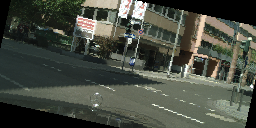
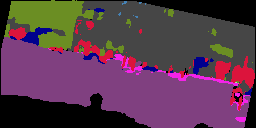
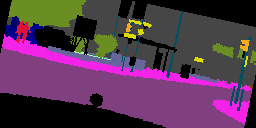

In [ ]:

# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

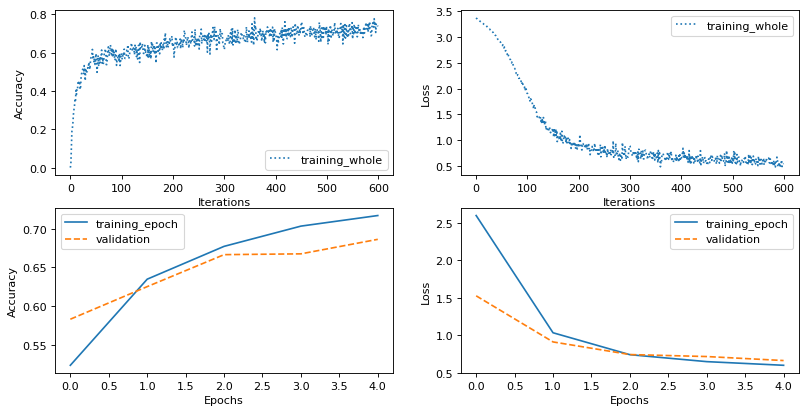

In [ ]:
import time

def plot_train_val(df_train,df_val,trainer):
  train_acc = df_train.groupby('epoch')['accuracy'].mean()
  train_loss = df_train.groupby('epoch')['loss'].mean()

  fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
  ax = plt.subplot(2,2,1)
  ax.plot(range(len(df_train)),df_train['accuracy'],label='training_whole',linestyle=':')
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Iterations')

  ax = plt.subplot(2,2,2)
  ax.plot(range(len(df_train)),df_train['loss'],label='training_whole',linestyle=':')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Iterations')
  ax.legend()

  ax = plt.subplot(2,2,3)
  ax.plot(range(trainer.epochs), train_acc,label='training_epoch')
  ax.plot(range(trainer.epochs), df_val['accuracy'], label="validation",linestyle='--')
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epochs')

  ax = plt.subplot(2,2,4)
  ax.plot(range(trainer.epochs), train_loss,label='training_epoch')
  ax.plot(range(trainer.epochs), df_val['loss'], label="validation",linestyle='--')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epochs')
  ax.legend()

  plt.show()

plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)

## HFlip

In [ ]:
# Create one instance of the CityscapesDataset for each split type
# del ds_split_aug5_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['HFlip'])
    for name in ("train", "val", "test")
}

In [ ]:
# train model 1 with augmentation aug=['HFlip','Rotate'] only

# Model 1 shallow UNet
from Model1.shallow_uNet import shallow_UNet
from Model1.initialize_weights_baseline import initialize_weights_baseline

model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet with aug=['HFlip']...")
model_shallow_unet.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

# use IoU rather than iIoU
mit_bias = False
df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()


Training process for shallow_UNet with aug=['HFlip']...
Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 115.95it/s, accuracy=0.666, loss=1.28]

Validation loss is 0.07188232809305191, validation accuracy is 0.5908129349350929
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 116.00it/s, accuracy=0.76, loss=0.606] 

Validation loss is 0.0414389356970787, validation accuracy is 0.657768389582634
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.93it/s, accuracy=0.747, loss=0.561]

Validation loss is 0.03659429118037224, validation accuracy is 0.6741875350475312
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 115.45it/s, accuracy=0.786, loss=0.474]

Validation loss is 0.032774024084210394, validation accuracy is 0.6971393465995789
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 115.20it/s, accuracy=0.796, loss=0.414]

Validation loss is 0.03024684265255928, validation accuracy is 0.7107694208621979


Illustration of shallwo Unet with aug=HFlip
Train accuracy in each epoch:epoch
1    0.467922
2    0.648130
3    0.696552
4    0.719847
5    0.733217
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.590813
1    0.657768
2    0.674188
3    0.697139
4    0.710769
Name: accuracy, dtype: float64


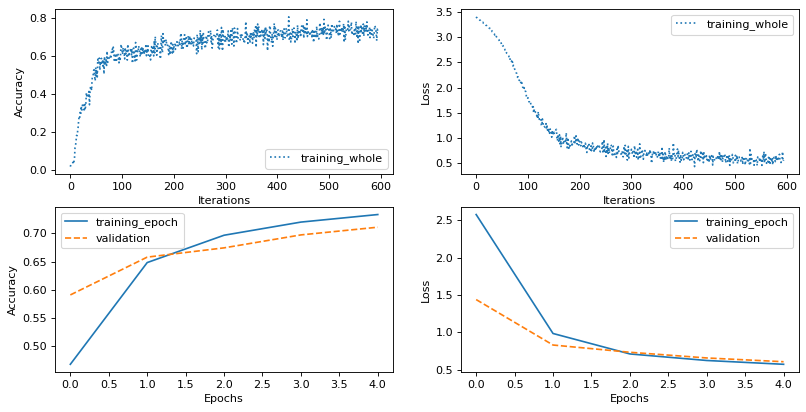

In [ ]:
print('Illustration of shallwo Unet with aug=HFlip')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)

## HFlip + Brightness

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['HFlip','Brightness'])
    for name in ("train", "val", "test")
}

In [ ]:
# Model 1 shallow UNet
from Model1.shallow_uNet import shallow_UNet
from Model1.initialize_weights_baseline import initialize_weights_baseline

model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet with aug=['HFlip','Brightness']...")
model_shallow_unet.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

# use IoU rather than iIoU
mit_bias = False
df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()


Training process for shallow_UNet with aug=['HFlip','Brightness']...
Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 114.99it/s, accuracy=0.644, loss=1.45]

Validation loss is 0.07963830173015594, validation accuracy is 0.5778295308351517
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.71it/s, accuracy=0.696, loss=0.734]

Validation loss is 0.046620498448610305, validation accuracy is 0.6263102874159813
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.50it/s, accuracy=0.743, loss=0.557]

Validation loss is 0.036468027532100676, validation accuracy is 0.6744711846113205
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.71it/s, accuracy=0.789, loss=0.458]

Validation loss is 0.0330328668653965, validation accuracy is 0.6977348238229751
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 111.43it/s, accuracy=0.793, loss=0.434]

Validation loss is 0.02999471664428711, validation accuracy is 0.7197713315486908


Illustration of shallwo Unet with aug=HFlip+Brightness
Train accuracy in each epoch:epoch
1    0.443498
2    0.624352
3    0.685887
4    0.710251
5    0.725795
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.577830
1    0.626310
2    0.674471
3    0.697735
4    0.719771
Name: accuracy, dtype: float64


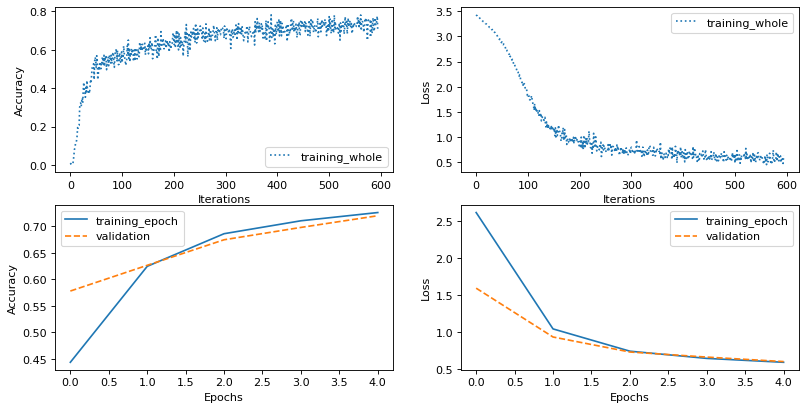

In [ ]:
print('Illustration of shallwo Unet with aug=HFlip+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


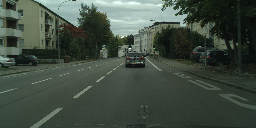
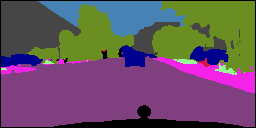
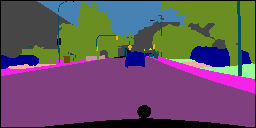

In [ ]:

# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Resized Crop + Gaussian Blur

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['ResizedCrop','GaussianBlur'])
    for name in ("train", "val", "test")
}

Training process for shallow_UNet with aug=['ResizedCrop','GaussianBlur']...
Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 112.34it/s, accuracy=0.539, loss=1.61]

Validation loss is 0.08535754978656769, validation accuracy is 0.5066821351647377
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.13it/s, accuracy=0.707, loss=0.718]

Validation loss is 0.04823187857866287, validation accuracy is 0.609244528412819
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.44it/s, accuracy=0.702, loss=0.723]

Validation loss is 0.04285301670432091, validation accuracy is 0.6395118534564972
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.59it/s, accuracy=0.72, loss=0.602] 

Validation loss is 0.03891203984618187, validation accuracy is 0.658681771159172
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.80it/s, accuracy=0.743, loss=0.567]


Validation loss is 0.03737447187304497, validation accuracy is 0.6690152212977409
Illustration of shallwo Unet with aug=ResizedCrop+GaussianBlur
Train accuracy in each epoch:epoch
1    0.433093
2    0.613527
3    0.682859
4    0.710692
5    0.724517
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.506682
1    0.609245
2    0.639512
3    0.658682
4    0.669015
Name: accuracy, dtype: float64


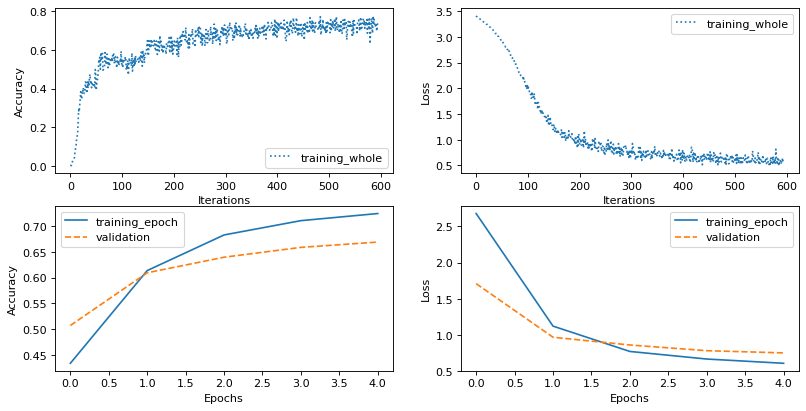

In [ ]:
model_shallow_unet = shallow_UNet(3,len(classes))
# Train the passthrough network
print("Training process for shallow_UNet with aug=['ResizedCrop','GaussianBlur']...")
model_shallow_unet.apply(initialize_weights_baseline)

trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=ResizedCrop+GaussianBlur')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


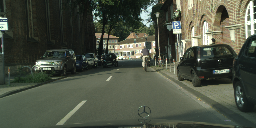
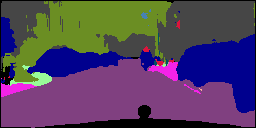
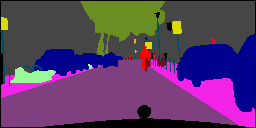

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## ResizedCrop + Brightness

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 113.66it/s, accuracy=0.606, loss=0.918]

Validation loss is 0.05302518397569657, validation accuracy is 0.5590236186981201
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.56it/s, accuracy=0.702, loss=0.639]

Validation loss is 0.041636636257171636, validation accuracy is 0.6285370647907257
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.93it/s, accuracy=0.748, loss=0.52] 

Validation loss is 0.03699345573782921, validation accuracy is 0.6610206812620163
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.87it/s, accuracy=0.758, loss=0.515]

Validation loss is 0.03521882966160774, validation accuracy is 0.6683298170566558
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 111.37it/s, accuracy=0.772, loss=0.494]


Validation loss is 0.033386187329888344, validation accuracy is 0.6937814593315125
Illustration of shallwo Unet with aug=ResizedCrop+Brightness
Train accuracy in each epoch:epoch
1    0.539793
2    0.640161
3    0.671552
4    0.692998
5    0.707546
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.559024
1    0.628537
2    0.661021
3    0.668330
4    0.693781
Name: accuracy, dtype: float64


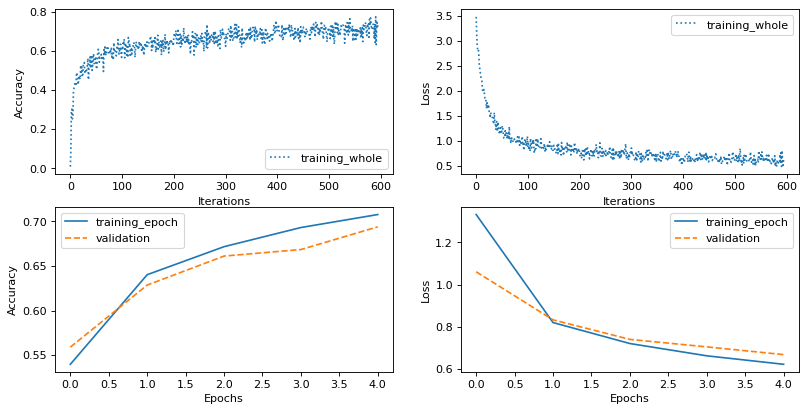

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['ResizedCrop','Brightness'])
    for name in ("train", "val", "test")
}

model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=ResizedCrop+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


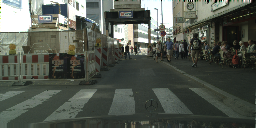
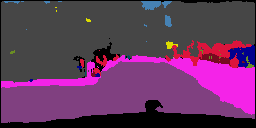
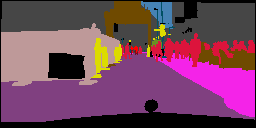

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Gaussian Blur

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 114.08it/s, accuracy=0.611, loss=0.849]

Validation loss is 0.05559624299407005, validation accuracy is 0.5328143045306206
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.96it/s, accuracy=0.679, loss=0.653]

Validation loss is 0.04230452194809914, validation accuracy is 0.6073976442217827
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.04it/s, accuracy=0.744, loss=0.513]

Validation loss is 0.03598173171281814, validation accuracy is 0.6607302203774452
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.12it/s, accuracy=0.744, loss=0.484]

Validation loss is 0.03401812359690666, validation accuracy is 0.6715997189283371
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.17it/s, accuracy=0.778, loss=0.453]


Validation loss is 0.03144020363688469, validation accuracy is 0.7010564416646957
Illustration of shallwo Unet with aug=ResizedCrop+Brightness
Train accuracy in each epoch:epoch
1    0.546614
2    0.650462
3    0.679011
4    0.700735
5    0.715268
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.532814
1    0.607398
2    0.660730
3    0.671600
4    0.701056
Name: accuracy, dtype: float64


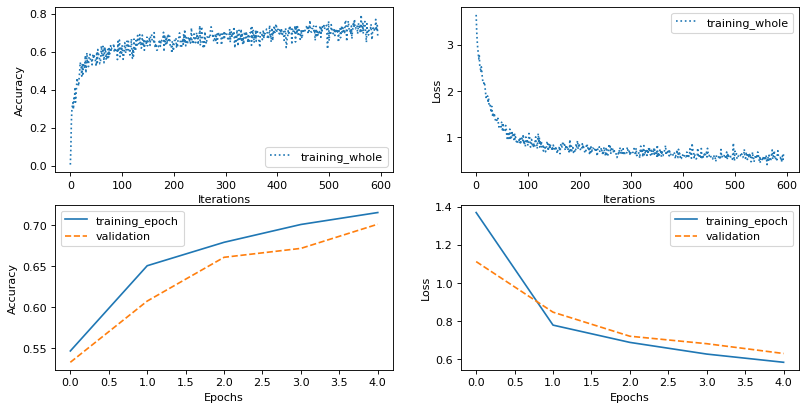

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['GaussianBlur'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=ResizedCrop+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


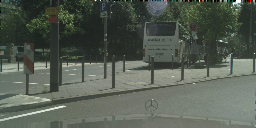
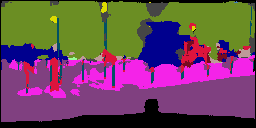
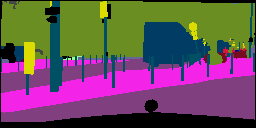

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Gaussian Blur+ Rotate

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 113.35it/s, accuracy=0.649, loss=0.812]

Validation loss is 0.0492901474237442, validation accuracy is 0.5737492248415947
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.05it/s, accuracy=0.713, loss=0.605]

Validation loss is 0.039437801241874695, validation accuracy is 0.6380155086517334
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.01it/s, accuracy=0.742, loss=0.534]

Validation loss is 0.035766988694667816, validation accuracy is 0.6700681239366532
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.08it/s, accuracy=0.745, loss=0.523]

Validation loss is 0.034459412246942524, validation accuracy is 0.6703617542982101
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.23it/s, accuracy=0.763, loss=0.477]


Validation loss is 0.03387672580778599, validation accuracy is 0.6789208382368088
Illustration of shallwo Unet with aug=GaussianBlur+Rotate
Train accuracy in each epoch:epoch
1    0.549664
2    0.642950
3    0.673829
4    0.696768
5    0.707344
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.573749
1    0.638016
2    0.670068
3    0.670362
4    0.678921
Name: accuracy, dtype: float64


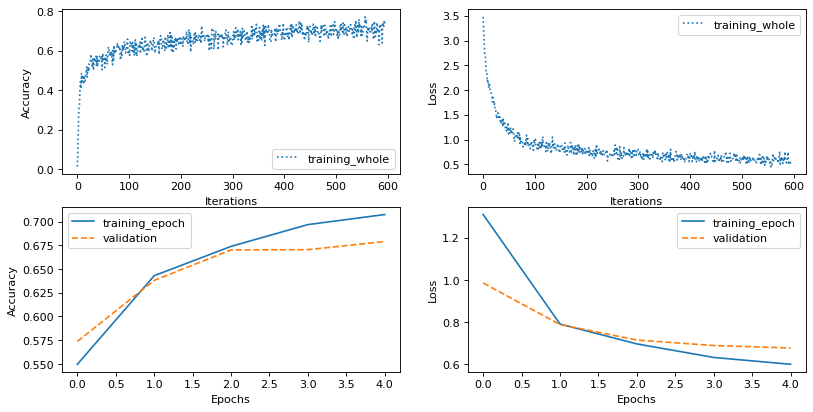

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['GaussianBlur','Rotate'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Rotate')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


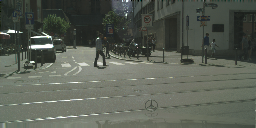
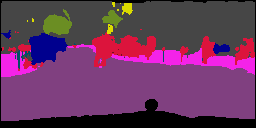
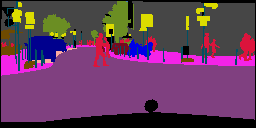

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Gaussian Blur+Brightness

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 112.85it/s, accuracy=0.645, loss=0.824]

Validation loss is 0.05087405607104302, validation accuracy is 0.5782300963997841
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.39it/s, accuracy=0.737, loss=0.564]

Validation loss is 0.03957304820418358, validation accuracy is 0.6402499213814735
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.42it/s, accuracy=0.757, loss=0.505]

Validation loss is 0.033566947579383846, validation accuracy is 0.6850443303585052
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.78it/s, accuracy=0.768, loss=0.469]

Validation loss is 0.03187421955168247, validation accuracy is 0.6956246018409729
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 111.74it/s, accuracy=0.733, loss=0.523]


Validation loss is 0.03380541801452637, validation accuracy is 0.6737466245889664
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.553112
2    0.654616
3    0.686528
4    0.705295
5    0.715748
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.578230
1    0.640250
2    0.685044
3    0.695625
4    0.673747
Name: accuracy, dtype: float64


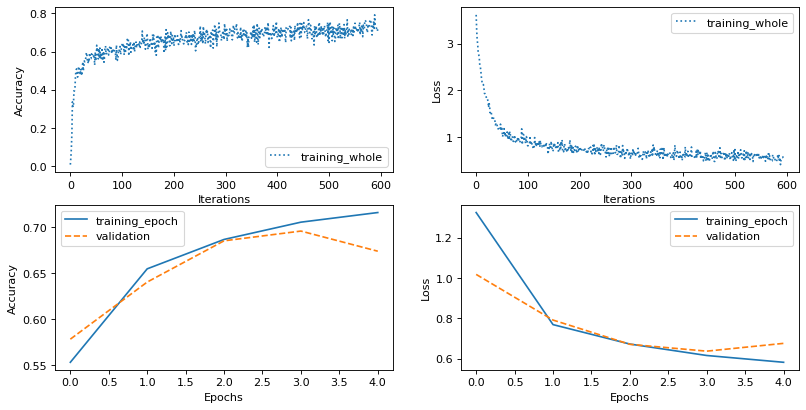

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['GaussianBlur','Brightness'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


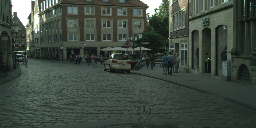
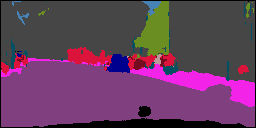
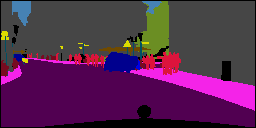

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Rotate + Brightness

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 114.40it/s, accuracy=0.609, loss=0.901]

Validation loss is 0.05427051767706871, validation accuracy is 0.5371661216020585
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.13it/s, accuracy=0.697, loss=0.638]

Validation loss is 0.04028373003005982, validation accuracy is 0.6350603714585304
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.76it/s, accuracy=0.749, loss=0.515]

Validation loss is 0.03477672770619392, validation accuracy is 0.6725871175527572
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.79it/s, accuracy=0.735, loss=0.527]

Validation loss is 0.03316258080303669, validation accuracy is 0.6833956688642502
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.90it/s, accuracy=0.752, loss=0.516]


Validation loss is 0.03361114799976349, validation accuracy is 0.6862370491027832
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.559712
2    0.655153
3    0.683058
4    0.701236
5    0.712411
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.537166
1    0.635060
2    0.672587
3    0.683396
4    0.686237
Name: accuracy, dtype: float64


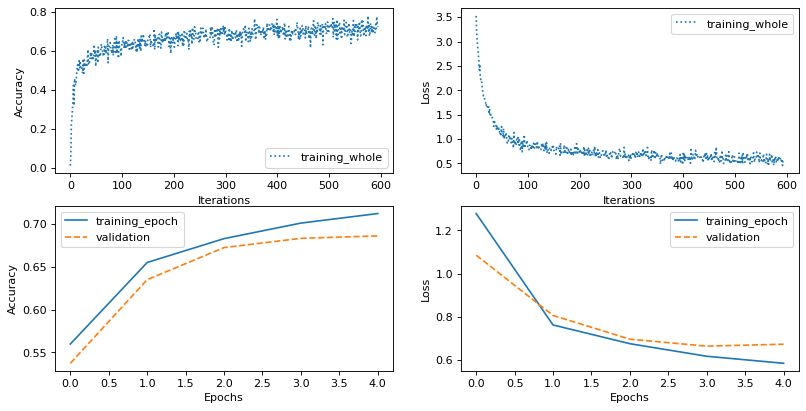

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['Rotate','Brightness'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)

In [ ]:
class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample],aug=[]):
        super(CityscapesDataset,self).__init__()
        
        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes
        self.aug = aug # switch for random augmentation methods, str or list in ['HFlip','ResizedCrop','GaussianBlur','Rotate','Brightness']
        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]
        input = self.load_input(sample)
        truth = self.load_truth(sample)
        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        # original images 
        path = os.path.join(self.dir_input, f'{sample.id}_leftImg8bit.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        # TODO:combine three different data augmentation methods and compare with single methods
        # random crop and resize back to original size, same on masks
        # disortation
        # gaussian blur
        # horizontally flip, same on masks
        ##################################################################################
        imgshower = transforms.ToPILImage() # code imgshower(img or tensor).show() to check img 
        # Convert the image to a tensor
        img = TF.to_tensor(img)
        
        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        if random.random()>0.8 and len(self.aug)>0: # data augmentation with possibility=0.5
            if 'Brightness' in self.aug:
                b = random.random() + 0.5 # range(0.5,1.5)
                img = TF.adjust_brightness(img,b)
            if 'Rotate' in self.aug:
                rotater = transforms.RandomRotation(degrees=(-15,15))
                degree = rotater.get_params(degrees=(-15,15))
                img = TF.rotate(img,degree)
                mask = TF.rotate(mask,degree)
            if 'GaussianBlur' in self.aug:
                blurrer = transforms.GaussianBlur(kernel_size=3,sigma=0.5)
                img = blurrer(img)
                # print('GaussianBlur finish')
            if 'ResizedCrop' in self.aug and random.random()>0.5: # Is this good for small objects?
                cropper_size = (128,256)
                resize_cropper = transforms.RandomResizedCrop(size = cropper_size)
                i,j,h,w = resize_cropper.get_params(img,scale=(0.6,1.0),ratio=(2,2))
                img = TF.resized_crop(img,i,j,h,w,size=cropper_size) #(3,128,256)
                mask = TF.resized_crop(mask,i,j,h,w,size=cropper_size)
            if 'HFlip' in self.aug:
                img = TF.hflip(img)
                mask = TF.hflip(mask)
                # print(img.size())
                # print(mask.size)
        ################################################################################# 
        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)

        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            temp = eq * i
            target += temp

        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(i)

            target[0] += eq * lbl.color[0]
            target[1] += eq * lbl.color[1]
            target[2] += eq * lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')

## Resized Crop + HFlip

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 114.12it/s, accuracy=0.688, loss=0.747]

Validation loss is 0.9779579609632492, validation accuracy is 0.5993035763502121
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.08it/s, accuracy=0.711, loss=0.638]

Validation loss is 0.8409897536039352, validation accuracy is 0.6267439872026443
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.32it/s, accuracy=0.757, loss=0.514]

Validation loss is 0.7031274855136871, validation accuracy is 0.6760915338993072
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.32it/s, accuracy=0.764, loss=0.493]

Validation loss is 0.6808980211615563, validation accuracy is 0.6781991750001908
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.71it/s, accuracy=0.739, loss=0.603]


Validation loss is 0.7221888720989227, validation accuracy is 0.6694280296564102
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.561222
2    0.658167
3    0.684039
4    0.703341
5    0.717664
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.599304
1    0.626744
2    0.676092
3    0.678199
4    0.669428
Name: accuracy, dtype: float64


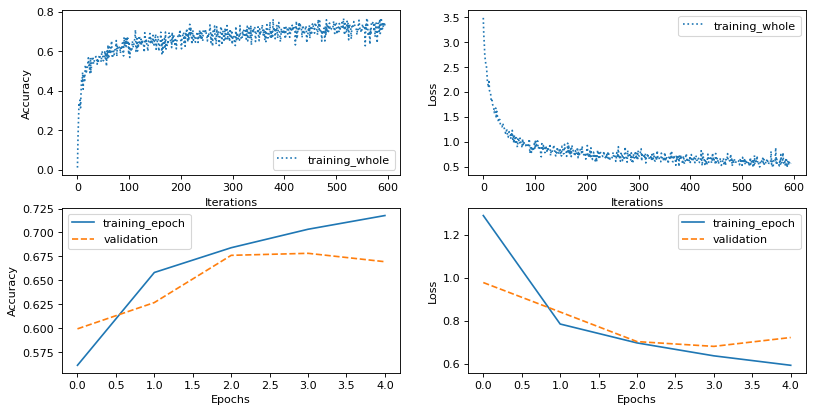

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['ResizedCrop','HFlip'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


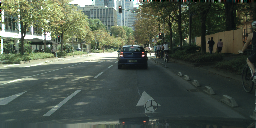
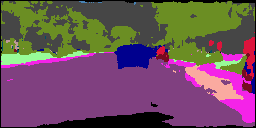
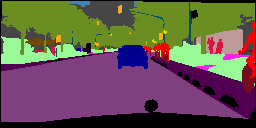

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Gaussian Blur + HFlip

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 114.61it/s, accuracy=0.694, loss=0.706]

Validation loss is 0.8924977481365204, validation accuracy is 0.6182237684726715
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.49it/s, accuracy=0.696, loss=0.674]

Validation loss is 0.8322085052728653, validation accuracy is 0.6330735996365547
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.19it/s, accuracy=0.73, loss=0.557] 

Validation loss is 0.7777119964361191, validation accuracy is 0.6313041940331459
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.05it/s, accuracy=0.754, loss=0.489]

Validation loss is 0.6508296638727188, validation accuracy is 0.68687002658844
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.26it/s, accuracy=0.766, loss=0.458]


Validation loss is 0.6355637848377228, validation accuracy is 0.6977365374565124
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.543969
2    0.647667
3    0.675917
4    0.695185
5    0.712099
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.618224
1    0.633074
2    0.631304
3    0.686870
4    0.697737
Name: accuracy, dtype: float64


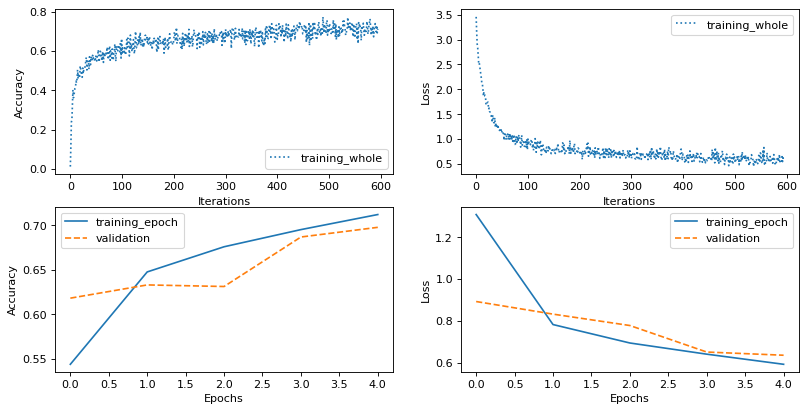

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['GaussianBlur','HFlip'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


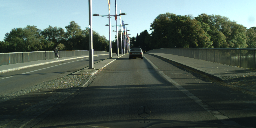

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Gaussian Blur + Resized Crop

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 113.95it/s, accuracy=0.67, loss=0.742] 

Validation loss is 0.9104850888252258, validation accuracy is 0.6094770967960358
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.61it/s, accuracy=0.658, loss=0.752]

Validation loss is 0.9899828553199768, validation accuracy is 0.576490604877472
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 111.61it/s, accuracy=0.766, loss=0.5]  

Validation loss is 0.7174998044967651, validation accuracy is 0.6747539609670639
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.53it/s, accuracy=0.758, loss=0.539]

Validation loss is 0.7277159094810486, validation accuracy is 0.6719660624861717
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.02it/s, accuracy=0.775, loss=0.474]


Validation loss is 0.6551473811268806, validation accuracy is 0.6973452121019363
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.562359
2    0.654735
3    0.681702
4    0.699543
5    0.713712
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.609477
1    0.576491
2    0.674754
3    0.671966
4    0.697345
Name: accuracy, dtype: float64


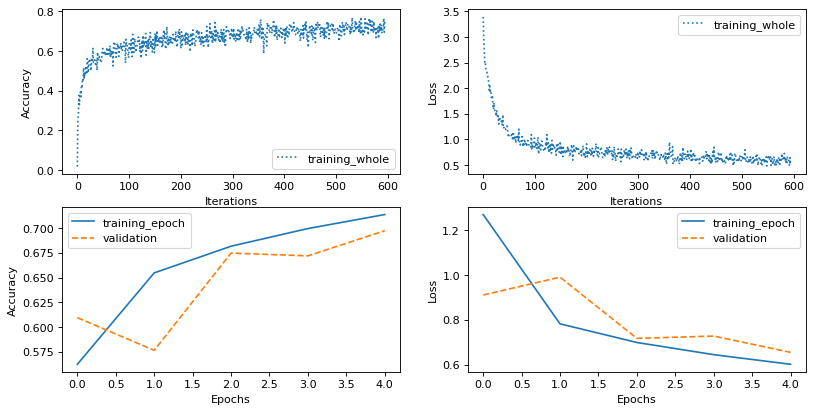

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['GaussianBlur','ResizedCrop'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


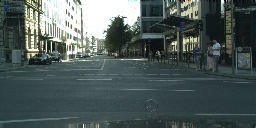
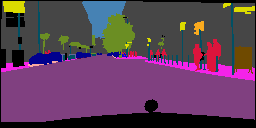

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Rotate + HFlip

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 113.96it/s, accuracy=0.656, loss=0.782]

Validation loss is 0.9809885948896409, validation accuracy is 0.5852136820554733
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.73it/s, accuracy=0.687, loss=0.658]

Validation loss is 0.8317497730255127, validation accuracy is 0.6215546220541001
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 111.91it/s, accuracy=0.721, loss=0.566]

Validation loss is 0.7352404534816742, validation accuracy is 0.6607796892523765
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 111.93it/s, accuracy=0.764, loss=0.477]

Validation loss is 0.7074845552444458, validation accuracy is 0.6590683266520501
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.98it/s, accuracy=0.768, loss=0.474]


Validation loss is 0.7172648131847381, validation accuracy is 0.6672542303800583
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.564132
2    0.654470
3    0.681834
4    0.700349
5    0.713179
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.585214
1    0.621555
2    0.660780
3    0.659068
4    0.667254
Name: accuracy, dtype: float64


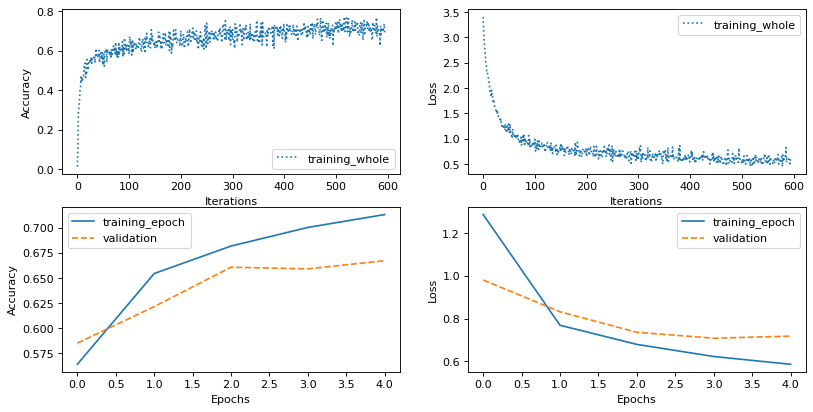

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['Rotate','HFlip'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


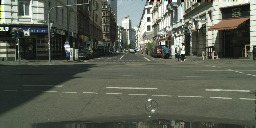
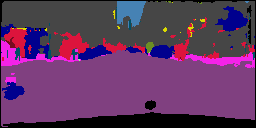

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Rotate + Resized Crop

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['Rotate','ResizedCrop'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 113.30it/s, accuracy=0.682, loss=0.738]

Validation loss is 0.964533942937851, validation accuracy is 0.5798280015587807
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.73it/s, accuracy=0.712, loss=0.637]

Validation loss is 0.8529722809791564, validation accuracy is 0.6194750547409058
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.43it/s, accuracy=0.682, loss=0.672]

Validation loss is 0.8612165182828904, validation accuracy is 0.6024648547172546
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.53it/s, accuracy=0.752, loss=0.522]

Validation loss is 0.701381403207779, validation accuracy is 0.6767422437667847
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.10it/s, accuracy=0.761, loss=0.506]


Validation loss is 0.6510558411478996, validation accuracy is 0.6917630195617676
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.552564
2    0.646711
3    0.675931
4    0.691363
5    0.709969
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.579828
1    0.619475
2    0.602465
3    0.676742
4    0.691763
Name: accuracy, dtype: float64



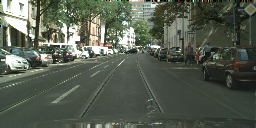
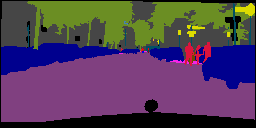

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Rotate +Gaussian Blur

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 111.31it/s, accuracy=0.683, loss=0.715]

Validation loss is 0.9470719039440155, validation accuracy is 0.5999524146318436
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.97it/s, accuracy=0.704, loss=0.627]

Validation loss is 0.8326187849044799, validation accuracy is 0.6158423811197281
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.96it/s, accuracy=0.755, loss=0.496]

Validation loss is 0.6922388941049575, validation accuracy is 0.6772979542613029
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.02it/s, accuracy=0.755, loss=0.491]

Validation loss is 0.676026725769043, validation accuracy is 0.6782088249921798
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.44it/s, accuracy=0.764, loss=0.476]


Validation loss is 0.6736826047301292, validation accuracy is 0.6668943792581559
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.552270
2    0.650109
3    0.680081
4    0.699613
5    0.710124
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.599952
1    0.615842
2    0.677298
3    0.678209
4    0.666894
Name: accuracy, dtype: float64


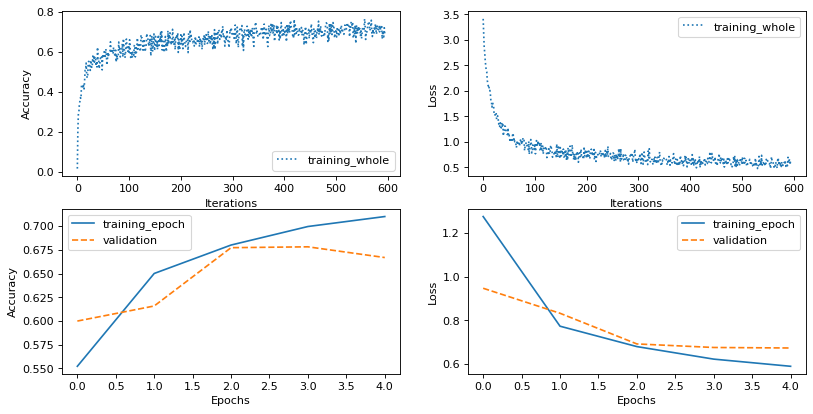

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['Rotate','GaussianBlur'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


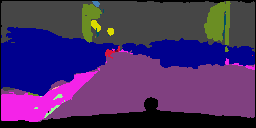
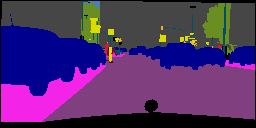

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Brightness + HFlip

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['Brightness','HFlip'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 113.94it/s, accuracy=0.641, loss=0.763]

Validation loss is 0.9427447140216827, validation accuracy is 0.5761013090610504
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 111.49it/s, accuracy=0.723, loss=0.58] 

Validation loss is 0.7577383577823639, validation accuracy is 0.6521349638700485
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.16it/s, accuracy=0.744, loss=0.511]

Validation loss is 0.7080196917057038, validation accuracy is 0.6629266783595085
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.11it/s, accuracy=0.746, loss=0.508]

Validation loss is 0.6760753244161606, validation accuracy is 0.6694075375795364
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 111.05it/s, accuracy=0.78, loss=0.425] 


Validation loss is 0.6050276383757591, validation accuracy is 0.7001938879489898
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.560711
2    0.656154
3    0.683871
4    0.704569
5    0.716599
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.576101
1    0.652135
2    0.662927
3    0.669408
4    0.700194
Name: accuracy, dtype: float64



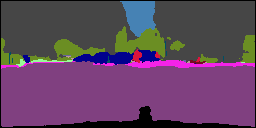
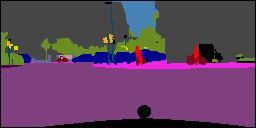

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Brightness + ResizedCrop

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 112.88it/s, accuracy=0.645, loss=0.808]

Validation loss is 0.9679478853940964, validation accuracy is 0.5908614844083786
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.41it/s, accuracy=0.717, loss=0.625]

Validation loss is 0.8378471910953522, validation accuracy is 0.6222081989049911
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.31it/s, accuracy=0.759, loss=0.532]

Validation loss is 0.7182292997837066, validation accuracy is 0.6737669050693512
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 114.40it/s, accuracy=0.76, loss=0.508] 

Validation loss is 0.6837173044681549, validation accuracy is 0.6818899512290955
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.71it/s, accuracy=0.744, loss=0.527]


Validation loss is 0.7012097850441933, validation accuracy is 0.6745042622089386
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.555290
2    0.649553
3    0.681131
4    0.700391
5    0.714359
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.590861
1    0.622208
2    0.673767
3    0.681890
4    0.674504
Name: accuracy, dtype: float64


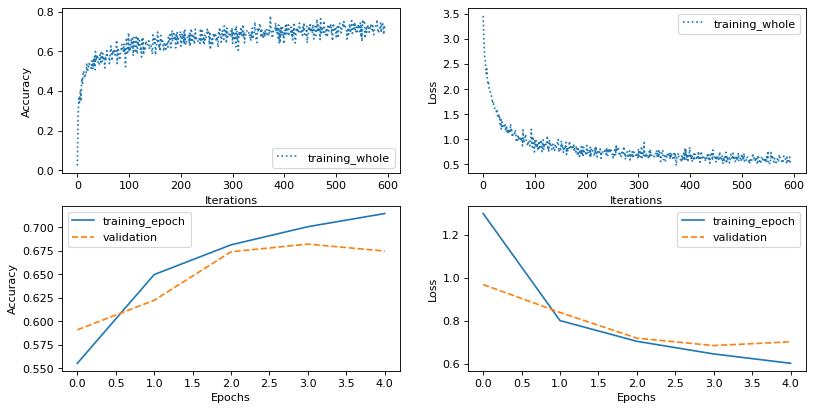

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['Brightness','ResizedCrop'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


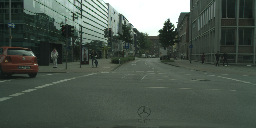
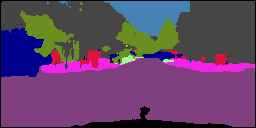
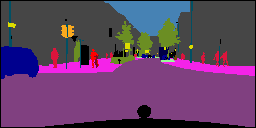

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Brightness + Gausssian Blur

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['Brightness','GaussianBlur'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 113.06it/s, accuracy=0.701, loss=0.686]

Validation loss is 0.8875632852315902, validation accuracy is 0.6110195413231849
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 111.76it/s, accuracy=0.497, loss=1.12] 

Validation loss is 1.1456369429826736, validation accuracy is 0.5034125402569771
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.32it/s, accuracy=0.654, loss=0.708]

Validation loss is 0.8744785904884338, validation accuracy is 0.5932923689484596
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.07it/s, accuracy=0.758, loss=0.484]

Validation loss is 0.6397335901856422, validation accuracy is 0.6940680742263794
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.13it/s, accuracy=0.773, loss=0.455]


Validation loss is 0.6564541816711426, validation accuracy is 0.6844617336988449
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.551411
2    0.651733
3    0.680644
4    0.701402
5    0.713569
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.611020
1    0.503413
2    0.593292
3    0.694068
4    0.684462
Name: accuracy, dtype: float64



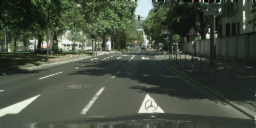
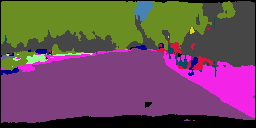
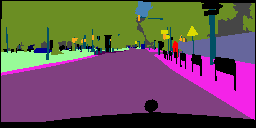

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Brightness + Rotate

Epoch 1


Validation: 100%|██████████| 500/500 [00:04<00:00, 113.18it/s, accuracy=0.687, loss=0.748]

Validation loss is 0.963789576292038, validation accuracy is 0.5899881705641746
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.79it/s, accuracy=0.701, loss=0.646]

Validation loss is 0.8501389414072037, validation accuracy is 0.6204671457409858
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.34it/s, accuracy=0.732, loss=0.55] 

Validation loss is 0.7512850254774094, validation accuracy is 0.6465066015720368
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 113.93it/s, accuracy=0.753, loss=0.498]

Validation loss is 0.6734348133206367, validation accuracy is 0.681282851099968
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 112.81it/s, accuracy=0.771, loss=0.477]


Validation loss is 0.6395131275057793, validation accuracy is 0.6967416644096375
Illustration of shallwo Unet with aug=GaussianBlur+Brightness
Train accuracy in each epoch:epoch
1    0.552135
2    0.645564
3    0.672653
4    0.691855
5    0.706175
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0    0.589988
1    0.620467
2    0.646507
3    0.681283
4    0.696742
Name: accuracy, dtype: float64


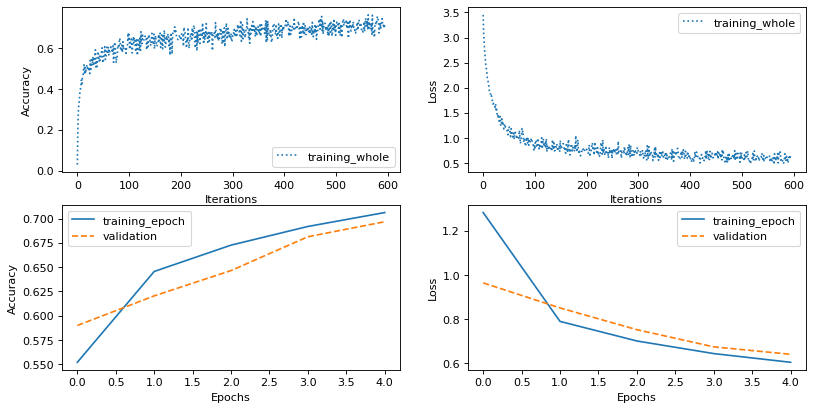

In [ ]:
del ds_split_aug6_shallow
ds_split_aug6_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['Brightness','Rotate'])
    for name in ("train", "val", "test")
}
model_shallow_unet = shallow_UNet(3,len(classes))
trainer_unet_baseline = Trainer(model_shallow_unet, ds_split_aug6_shallow,epochs=5, batch_size=25)

df_train_shallow_aug6, df_val_shallow_aug6 = trainer_unet_baseline.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug6, df_val_shallow_aug6,trainer_unet_baseline)


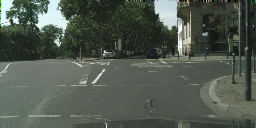
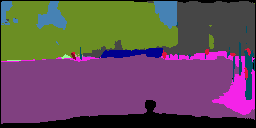

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug6_shallow["val"])
# Push through our network
model_shallow_unet = model_shallow_unet.cpu()
output = model_shallow_unet(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug6_shallow["val"].to_image(ds_split_aug6_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug6_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Chose top 3 composition of data augmentation on ourmodel and give epoch=15 to see which one is the best

In [ ]:
# Model 1 shallow UNet
from ourmodel.crop_model1 import Unet_pro
from ourmodel.initialize_weights_baseline import initialize_weights_baseline

### 1.HFlip

In [ ]:

ds_split_aug7_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['HFlip'])
    for name in ("train", "val", "test")
}
crop_model = Unet_pro(3,len(classes))
crop_model.apply(initialize_weights_baseline)
trainer_crop_model = Trainer(crop_model, ds_split_aug7_shallow,epochs=15, batch_size=20)

df_train_shallow_aug7, df_val_shallow_aug7 = trainer_crop_model.fit()



Epoch 1


Validation: 100%|██████████| 500/500 [00:05<00:00, 83.58it/s, accuracy=0.637, loss=1.09]

Validation loss is 1.2860392475128173, validation accuracy is 0.5615502524375916
Epoch 2



Validation: 100%|██████████| 500/500 [00:05<00:00, 83.47it/s, accuracy=0.728, loss=0.634]

Validation loss is 0.8702497863769532, validation accuracy is 0.6141137862205506
Epoch 3



Validation: 100%|██████████| 500/500 [00:06<00:00, 82.69it/s, accuracy=0.74, loss=0.558] 

Validation loss is 0.7843674898147583, validation accuracy is 0.6473486471176148
Epoch 4



Validation: 100%|██████████| 500/500 [00:05<00:00, 83.48it/s, accuracy=0.781, loss=0.452]

Validation loss is 0.650645581483841, validation accuracy is 0.6885181903839112
Epoch 5



Validation: 100%|██████████| 500/500 [00:05<00:00, 83.65it/s, accuracy=0.785, loss=0.43] 

Validation loss is 0.616277893781662, validation accuracy is 0.6967578697204589
Epoch 6



Validation: 100%|██████████| 500/500 [00:05<00:00, 84.06it/s, accuracy=0.784, loss=0.436]

Validation loss is 0.587726148366928, validation accuracy is 0.7159892201423645
Epoch 7



Validation: 100%|██████████| 500/500 [00:05<00:00, 83.69it/s, accuracy=0.787, loss=0.422]

Validation loss is 0.5761594700813294, validation accuracy is 0.718428282737732
Epoch 8



Validation: 100%|██████████| 500/500 [00:05<00:00, 84.48it/s, accuracy=0.819, loss=0.341]

Validation loss is 0.5248186469078064, validation accuracy is 0.740198757648468
Epoch 9



Validation: 100%|██████████| 500/500 [00:05<00:00, 84.30it/s, accuracy=0.821, loss=0.343]

Validation loss is 0.5325157237052918, validation accuracy is 0.7255814409255982
Epoch 10



Validation: 100%|██████████| 500/500 [00:05<00:00, 84.40it/s, accuracy=0.829, loss=0.324]

Validation loss is 0.496955041885376, validation accuracy is 0.7454027318954468
Epoch 11



Validation: 100%|██████████| 500/500 [00:05<00:00, 84.34it/s, accuracy=0.807, loss=0.366]

Validation loss is 0.5195687079429626, validation accuracy is 0.7328657126426696
Epoch 12



Validation: 100%|██████████| 500/500 [00:05<00:00, 83.97it/s, accuracy=0.832, loss=0.334]

Validation loss is 0.5037911295890808, validation accuracy is 0.7349204206466675
Epoch 13



Validation: 100%|██████████| 500/500 [00:05<00:00, 84.29it/s, accuracy=0.834, loss=0.295]

Validation loss is 0.48771072387695313, validation accuracy is 0.7520118093490601
Epoch 14



Validation: 100%|██████████| 500/500 [00:06<00:00, 83.17it/s, accuracy=0.839, loss=0.3]  

Validation loss is 0.47757180452346804, validation accuracy is 0.7483191800117492
Epoch 15



Validation: 100%|██████████| 500/500 [00:06<00:00, 83.27it/s, accuracy=0.842, loss=0.287]

Validation loss is 0.47302721977233886, validation accuracy is 0.7506052398681641
Illustration of shallwo Unet with aug=GaussianBlur+Brightness


NameError: name 'plot_train_val' is not defined

Train accuracy in each epoch:epoch
1     0.484437
2     0.654827
3     0.693926
4     0.714792
5     0.727267
6     0.738044
7     0.748380
8     0.755377
9     0.760921
10    0.768234
11    0.773173
12    0.776069
13    0.781181
14    0.784708
15    0.791084
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0     0.561550
1     0.614114
2     0.647349
3     0.688518
4     0.696758
5     0.715989
6     0.718428
7     0.740199
8     0.725581
9     0.745403
10    0.732866
11    0.734920
12    0.752012
13    0.748319
14    0.750605
Name: accuracy, dtype: float64


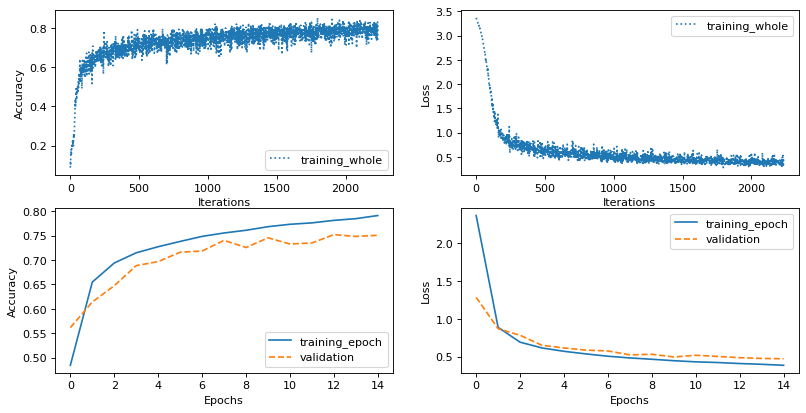

In [ ]:
def plot_train_val(df_train,df_val,trainer):
  train_acc = df_train.groupby('epoch')['accuracy'].mean()
  train_loss = df_train.groupby('epoch')['loss'].mean()

  fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
  ax = plt.subplot(2,2,1)
  ax.plot(range(len(df_train)),df_train['accuracy'],label='training_whole',linestyle=':')
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Iterations')

  ax = plt.subplot(2,2,2)
  ax.plot(range(len(df_train)),df_train['loss'],label='training_whole',linestyle=':')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Iterations')
  ax.legend()

  ax = plt.subplot(2,2,3)
  ax.plot(range(trainer.epochs), train_acc,label='training_epoch')
  ax.plot(range(trainer.epochs), df_val['accuracy'], label="validation",linestyle='--')
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epochs')
  print(f'Train accuracy in each epoch:{train_acc}.')
  print('Validation accuracy in each epoch.\n')
  print(df_val['accuracy'])

  ax = plt.subplot(2,2,4)
  ax.plot(range(trainer.epochs), train_loss,label='training_epoch')
  ax.plot(range(trainer.epochs), df_val['loss'], label="validation",linestyle='--')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epochs')
  ax.legend()

  plt.show()
plot_train_val(df_train_shallow_aug7, df_val_shallow_aug7,trainer_crop_model)


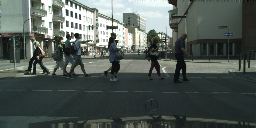
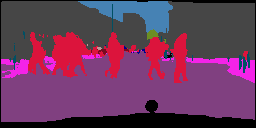
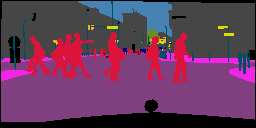

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug7_shallow["val"])
# Push through our network
crop_model = crop_model.cpu()
output = crop_model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug7_shallow["val"].to_image(ds_split_aug7_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug7_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

### 2.HFlip + GaussianBlur

In [ ]:

ds_split_aug7_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['HFlip','GaussianBlur'])
    for name in ("train", "val", "test")
}
crop_model = Unet_pro(3,len(classes))
crop_model.apply(initialize_weights_baseline)
trainer_crop_model = Trainer(crop_model, ds_split_aug7_shallow,epochs=15, batch_size=20)

df_train_shallow_aug7, df_val_shallow_aug7 = trainer_crop_model.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug7, df_val_shallow_aug7,trainer_crop_model)

Epoch 1


Validation: 100%|██████████| 500/500 [00:05<00:00, 83.52it/s, accuracy=0.652, loss=1.1] 

Validation loss is 1.225033450126648, validation accuracy is 0.5893064212799072
Epoch 2



Validation: 100%|██████████| 500/500 [00:05<00:00, 83.38it/s, accuracy=0.733, loss=0.619]

Validation loss is 0.8048789572715759, validation accuracy is 0.6608453059196472
Epoch 3



Validation: 100%|██████████| 500/500 [00:06<00:00, 82.45it/s, accuracy=0.727, loss=0.592]

Validation loss is 0.8245625829696656, validation accuracy is 0.6147633147239685
Epoch 4



Validation: 100%|██████████| 500/500 [00:06<00:00, 82.87it/s, accuracy=0.765, loss=0.485]

Validation loss is 0.6589185273647309, validation accuracy is 0.6929565501213074
Epoch 5



Training:  28%|██▊       | 840/2975 [00:27<01:09, 30.88it/s, accuracy=0.731, loss=0.555]

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug7_shallow["val"])
# Push through our network
crop_model = crop_model.cpu()
output = crop_model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug7_shallow["val"].to_image(ds_split_aug7_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug7_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

### 3. HFlip+Brightness 

In [ ]:

ds_split_aug7_shallow = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes,aug=['HFlip','Brightness'])
    for name in ("train", "val", "test")
}
crop_model = Unet_pro(3,len(classes))
crop_model.apply(initialize_weights_baseline)
trainer_crop_model = Trainer(crop_model, ds_split_aug7_shallow,epochs=15, batch_size=20)

df_train_shallow_aug7, df_val_shallow_aug7 = trainer_crop_model.fit()

print('Illustration of shallwo Unet with aug=GaussianBlur+Brightness')
plot_train_val(df_train_shallow_aug7, df_val_shallow_aug7,trainer_crop_model)

In [ ]:
# Draw a random sample
input, truth = random.choice(ds_split_aug7_shallow["val"])
# Push through our network
crop_model = crop_model.cpu()
output = crop_model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_aug7_shallow["val"].to_image(ds_split_aug7_shallow["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_aug7_shallow["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Baseline epoch=15

Training process for UNet Baseline...
Epoch 1


Training:   0%|          | 0/2975 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /home/mist/pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Validation: 100%|██████████| 500/500 [00:04<00:00, 101.89it/s, accuracy=0.624, loss=1.46]

Validation loss is 1.5678705036640168, validation accuracy is 0.5596488788723946
Epoch 2



Validation: 100%|██████████| 500/500 [00:04<00:00, 102.87it/s, accuracy=0.699, loss=0.728]

Validation loss is 0.9180868357419968, validation accuracy is 0.6203641429543495
Epoch 3



Validation: 100%|██████████| 500/500 [00:04<00:00, 102.42it/s, accuracy=0.747, loss=0.555]

Validation loss is 0.7409121572971344, validation accuracy is 0.6629003524780274
Epoch 4



Validation: 100%|██████████| 500/500 [00:04<00:00, 102.56it/s, accuracy=0.753, loss=0.513]

Validation loss is 0.6779892936348915, validation accuracy is 0.6757690593600273
Epoch 5



Validation: 100%|██████████| 500/500 [00:04<00:00, 100.80it/s, accuracy=0.761, loss=0.508]

Validation loss is 0.7047917038202286, validation accuracy is 0.6791600480675697
Epoch 6



Validation: 100%|██████████| 500/500 [00:04<00:00, 102.39it/s, accuracy=0.796, loss=0.42] 

Validation loss is 0.5885746419429779, validation accuracy is 0.7157025784254074
Epoch 7



Validation: 100%|██████████| 500/500 [00:04<00:00, 103.10it/s, accuracy=0.788, loss=0.415]

Validation loss is 0.5895994007587433, validation accuracy is 0.7104562520980835
Epoch 8



Validation: 100%|██████████| 500/500 [00:04<00:00, 102.52it/s, accuracy=0.803, loss=0.392]

Validation loss is 0.5563559874892234, validation accuracy is 0.7235092520713806
Epoch 9



Validation: 100%|██████████| 500/500 [00:04<00:00, 102.93it/s, accuracy=0.803, loss=0.377]

Validation loss is 0.5547262281179428, validation accuracy is 0.7128520756959915
Epoch 10



Validation: 100%|██████████| 500/500 [00:04<00:00, 103.00it/s, accuracy=0.803, loss=0.377]

Validation loss is 0.5364664375782013, validation accuracy is 0.7263589262962341
Epoch 11



Validation: 100%|██████████| 500/500 [00:04<00:00, 103.14it/s, accuracy=0.809, loss=0.37] 

Validation loss is 0.5350283548235893, validation accuracy is 0.7213919639587403
Epoch 12



Validation: 100%|██████████| 500/500 [00:04<00:00, 102.71it/s, accuracy=0.826, loss=0.332]

Validation loss is 0.5097380250692367, validation accuracy is 0.7413007199764252
Epoch 13



Validation: 100%|██████████| 500/500 [00:04<00:00, 103.02it/s, accuracy=0.816, loss=0.341]

Validation loss is 0.5111440971493721, validation accuracy is 0.730740612745285
Epoch 14



Validation: 100%|██████████| 500/500 [00:04<00:00, 103.15it/s, accuracy=0.816, loss=0.364]

Validation loss is 0.527252808213234, validation accuracy is 0.7382085442543029
Epoch 15



Validation: 100%|██████████| 500/500 [00:04<00:00, 102.66it/s, accuracy=0.792, loss=0.397]


Validation loss is 0.569667574763298, validation accuracy is 0.7222199499607086



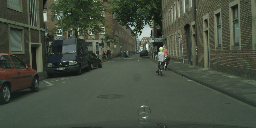
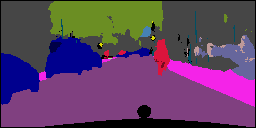
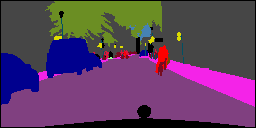

In [ ]:
from UNetBaseline.uNet import UNet
from UNetBaseline.initialize_weights_baseline import initialize_weights_baseline

# Create one instance of the CityscapesDataset for each split type
ds_split_UNet_bl = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes, aug=['Rotate'])
    for name in ("train", "val", "test")
}

model_unet_baseline = UNet(3,len(classes))
# Train the passthrough network
print("Training process for UNet Baseline...")
model_unet_baseline.apply(initialize_weights_baseline)
trainer_unet_baseline = Trainer(model_unet_baseline, ds_split_UNet_bl,epochs=15, batch_size=25)

df_train, df_val = trainer_unet_baseline.fit() 

# Draw a random sample
input, truth = random.choice(ds_split_UNet_bl["val"])

# Push through our network
model_unet_baseline = model_unet_baseline.cpu()
output = model_unet_baseline(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split_UNet_bl["val"].to_image(ds_split_UNet_bl["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split_UNet_bl["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

Train accuracy in each epoch:epoch
1     0.498232
2     0.631712
3     0.685789
4     0.708457
5     0.722884
6     0.733656
7     0.742010
8     0.751365
9     0.759134
10    0.763880
11    0.769980
12    0.779867
13    0.782343
14    0.788445
15    0.793689
Name: accuracy, dtype: float64.
Validation accuracy in each epoch.

0     0.559649
1     0.620364
2     0.662900
3     0.675769
4     0.679160
5     0.715703
6     0.710456
7     0.723509
8     0.712852
9     0.726359
10    0.721392
11    0.741301
12    0.730741
13    0.738209
14    0.722220
Name: accuracy, dtype: float64


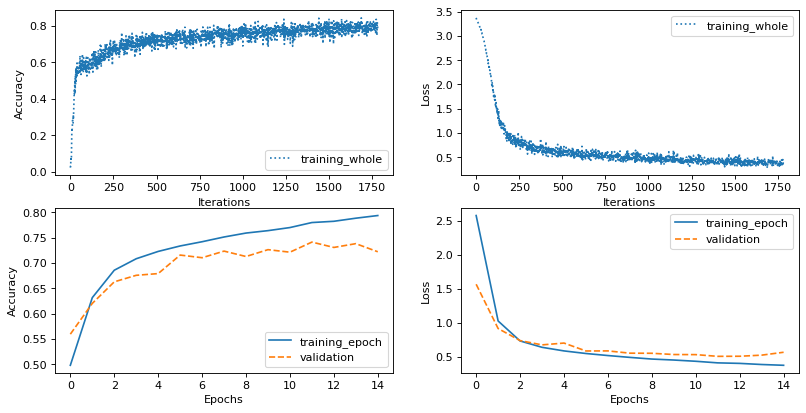

In [ ]:
def plot_train_val(df_train,df_val,trainer):
  train_acc = df_train.groupby('epoch')['accuracy'].mean()
  train_loss = df_train.groupby('epoch')['loss'].mean()

  fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
  ax = plt.subplot(2,2,1)
  ax.plot(range(len(df_train)),df_train['accuracy'],label='training_whole',linestyle=':')
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Iterations')

  ax = plt.subplot(2,2,2)
  ax.plot(range(len(df_train)),df_train['loss'],label='training_whole',linestyle=':')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Iterations')
  ax.legend()

  ax = plt.subplot(2,2,3)
  ax.plot(range(trainer.epochs), train_acc,label='training_epoch')
  ax.plot(range(trainer.epochs), df_val['accuracy'], label="validation",linestyle='--')
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epochs')
  print(f'Train accuracy in each epoch:{train_acc}.')
  print('Validation accuracy in each epoch.\n')
  print(df_val['accuracy'])

  ax = plt.subplot(2,2,4)
  ax.plot(range(trainer.epochs), train_loss,label='training_epoch')
  ax.plot(range(trainer.epochs), df_val['loss'], label="validation",linestyle='--')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epochs')
  ax.legend()

  plt.show()

plot_train_val(df_train, df_val,trainer_unet_baseline)

## Troubleshooting

###### There is not enough memory on my GPU to define any practical network.
We already downsampled the images in the preprocessing section of the notebook. Before downsampling further, try reducing your `batch_size` on the `Trainer` class.

###### My assignment partner keeps overwriting my changes
Consider splitting up the notebook and your networks into multiple python files and using a Git repository for version control.

###### There is not enough memory on my PC to store the dataset
Connect a USB-drive and point the `dir_data` variable to this location.

_Created by Kurt Stolle, last modified 2021-03-14_